# Gold recovery from ore


We need to prepare a prototype machine learning model for Zifra. The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold ore. We have to use data with mining and cleaning parameters.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

We need to:

1. Prepare data;
2. Conduct exploratory data analysis;
3. Build and train the model.

To complete the project, refer to *pandas*, *matplotlib* and *sklearn libraries*. Their documentation will help us.

**Data Description:**

1) the name of the signs:

    - [stage].[parameter_type].[parameter_name]
    **Example:** final.output.concentrate_ag
    
2) possible value for block [stage]:

    - rougher - flotation
    - primary_cleaner - primary cleaning
    - secondary_cleaner - secondary cleaning
    - final - final cleaning
    
3) possible value for block [parameter_type]:

    - input - raw material parameters
    - output - product parameters
    - state - parameters characterizing the current state of the stages
    - calculation - calculated characteristics
    
4) parameters of stages:

    - air amount - air volume
    - fleet levels - fluid level
    - feed size - feed granule size
    - feed rate - feed rate
    
**Steps of project:**

1. Data preparation:

    1.1 data exploration
    
    1.2 verification of enrichment efficiency calculations
    
    1.3 analysis of features not available in the test sample
    
    1.4 data preprocessing

2. Data analysis:

    2.1 analysis of changes in the concentration of metals (Au, Ag, Pb)
    
    2.2 Comparison of the size distribution of raw material granules
    
    2.3 research of the total concentrations of substances depending on the stage of processing (in raw materials, in rough and final concentrates)
    
3. Model building
    
    3.1 function for determining sMAPE totals
    
    3.2 training and model quality assessment
    
    3.3 model testing

## Data preparation

On this step we will carry out the following steps:

   1.1 data exploration
    
   1.2 verification of enrichment efficiency calculations
    
   1.3 analysis of features not available in the test sample
    
   1.4 data preprocessing

### 1.1 Data exploration

In [1]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from scipy import stats as st

In [2]:
# write a function to get general information about a dataset
def data_info(file_path):
    """
    The function returns information about the dataset:
    - general information
    - size
    - column names
    - presence of duplicates
    - percentage of missing values
    """
    
    data = pd.read_csv(file_path, index_col = 'date')
    print('=' * 10, 'Общая информация', '=' * 10)
    print(data.info())
    print()
    print('=' * 10, 'Наименования колонок', '=' * 10)
    print(data.columns)
    print()
    print('=' * 10, 'Размер таблицы', '=' * 10)
    print(data.shape)
    print()
    print('=' * 10, 'Наличие дубликатов', '=' * 10)
    print('Количество дубликатов', data.duplicated().sum())
    print()
    print('=' * 10, 'Процент пропусков', '=' * 10)
    for col in data.columns:
        pct_missing = np.mean(data[col].isna())
        print(f'{col} - {round(pct_missing * 100)}%')
    
    return data

Display information on the train dataset and store the data in the data_train variable

In [3]:
# display information about train
data_train = data_info('....csv')

========== Общая информация ==========
<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.outp

In [4]:
# display the first 5 rows of table train
data_train.head()

final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   

                     final.output.concentrate_au  final.output.recovery  \
date                                                                      
2016-01-15 00:00:00                    42.192020              70.541216   
2016-01-15 01:00:00                    42.701629              69.266198   
2016-01-15 02:00:00                    42.657501              68.116445   
2016-01-15 03:00:00                    42.689819              68.347543   
2016-01-15 04:00:00                    42.774141              66.927016   

                     final.output.tail_ag  final.output.tail_pb  \
date                                                              
2016-01-15 00:00:00             10.411962              0.895447   
2016-01-15 01:00:00             10.462676              0.927452   
2016-01-15 02:00:00             10.507046              0.953716   
2016-01-15 03:00:00             10.422762              0.883763   
2016-01-15 04:00:00             10.360302              0.792826   

                     final.output.tail_sol  final.output.tail_au  \
date                                                               
2016-01-15 00:00:00              16.904297              2.143149   
2016-01-15 01:00:00              16.634514              2.224930   
2016-01-15 02:00:00              16.208849              2.257889   
2016-01-15 03:00:00              16.532835              2.146849   
2016-01-15 04:00:00              16.525686              2.055292   

                     primary_cleaner.input.sulfate  ...  \
date                                                ...   
2016-01-15 00:00:00                     127.092003  ...   
2016-01-15 01:00:00                     125.629232  ...   
2016-01-15 02:00:00                     123.819808  ...   
2016-01-15 03:00:00                     122.270188  ...   
2016-01-15 04:00:00                     117.988169  ...   

                     secondary_cleaner.state.floatbank4_a_air  \
date                                                            
2016-01-15 00:00:00                                 14.016835   
2016-01-15 01:00:00                                 13.992281   
2016-01-15 02:00:00                                 14.015015   
2016-01-15 03:00:00                                 14.036510   
2016-01-15 04:00:00                                 14.027298   

                     secondary_cleaner.state.floatbank4_a_level  \
date                                                              
2016-01-15 00:00:00                                 -502.488007   
2016-01-15 01:00:00                                 -505.503262   
2016-01-15 02:00:00                                 -502.520901   
2016-01-15 03:00:00                                 -500.857308   
2016-01-15 04:00:00                                 -499.838632   

                     secondary_cleaner.state.floatbank4_b_air  \
date                                                            
2016-01-15 00:00:00                                 12.099931   
2016-01-15 01:00:00                                 11.950531   
2016-01-

Display information on the data set test and save the data to the variable data_test

In [5]:
data_test = data_info('....csv')

========== Общая информация ==========
<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.st

In [6]:
data_test.head()

primary_cleaner.input.sulfate  \
date                                                 
2016-09-01 00:59:59                     210.800909   
2016-09-01 01:59:59                     215.392455   
2016-09-01 02:59:59                     215.259946   
2016-09-01 03:59:59                     215.336236   
2016-09-01 04:59:59                     199.099327   

                     primary_cleaner.input.depressant  \
date                                                    
2016-09-01 00:59:59                         14.993118   
2016-09-01 01:59:59                         14.987471   
2016-09-01 02:59:59                         12.884934   
2016-09-01 03:59:59                         12.006805   
2016-09-01 04:59:59                         10.682530   

                     primary_cleaner.input.feed_size  \
date                                                   
2016-09-01 00:59:59                         8.080000   
2016-09-01 01:59:59                         8.080000   
2016-09-01 02:59:59                         7.786667   
2016-09-01 03:59:59                         7.640000   
2016-09-01 04:59:59                         7.530000   

                     primary_cleaner.input.xanthate  \
date                                                  
2016-09-01 00:59:59                        1.005021   
2016-09-01 01:59:59                        0.990469   
2016-09-01 02:59:59                        0.996043   
2016-09-01 03:59:59                        0.863514   
2016-09-01 04:59:59                        0.805575   

                     primary_cleaner.state.floatbank8_a_air  \
date                                                          
2016-09-01 00:59:59                             1398.981301   
2016-09-01 01:59:59                             1398.777912   
2016-09-01 02:59:59                             1398.493666   
2016-09-01 03:59:59                             1399.618111   
2016-09-01 04:59:59                             1401.268123   

                     primary_cleaner.state.floatbank8_a_level  \
date                                                            
2016-09-01 00:59:59                               -500.225577   
2016-09-01 01:59:59                               -500.057435   
2016-09-01 02:59:59                               -500.868360   
2016-09-01 03:59:59                               -498.863574   
2016-09-01 04:59:59                               -500.808305   

                     primary_cleaner.state.floatbank8_b_air  \
date                                                          
2016-09-01 00:59:59                             1399.144926   
2016-09-01 01:59:59                             1398.055362   
2016-09-01 02:59:59                             1398.860436   
2016-09-01 03:59:59                             1397.440120   
2016-09-01 04:59:59                             1398.128818   

                     primary_cleaner.state.floatbank8_b_level  \
date                                                            
2016-09-01 00:59:59                               -499.919735   
2016-09-01 01:59:59                               -499.778182   
2016-09-01 02:59:59                               -499.764529   
2016-09-01 03:59:59                               -499.211024   
2016-09-01 04:59:59                               -499.504543   

                     primary_cleaner.state.floatbank8_c_air  \
date                                                          
2016-09-01 00:59:59                             1400.102998   
2016-09-01 01:59:59                             1396.151033   
2016-09-01 02:59:59                             1398.075709   
2016-09-01 03:59:59                             1400.129303   
2016-09-01 04:59:59                             1402.172226   

                     primary_cleaner.state.floatbank8_c_level  ...  \
date                                                           ...   
2016-09-01 00:59:59                               -500.704369  ...   
2016-09-01 01:5

Display information on the full dataset and store the data in data_full

In [7]:
data_full = data_info('....csv')

========== Общая информация ==========
<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.outp

In [8]:
data_full.head()

final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   

                     final.output.concentrate_au  final.output.recovery  \
date                                                                      
2016-01-15 00:00:00                    42.192020              70.541216   
2016-01-15 01:00:00                    42.701629              69.266198   
2016-01-15 02:00:00                    42.657501              68.116445   
2016-01-15 03:00:00                    42.689819              68.347543   
2016-01-15 04:00:00                    42.774141              66.927016   

                     final.output.tail_ag  final.output.tail_pb  \
date                                                              
2016-01-15 00:00:00             10.411962              0.895447   
2016-01-15 01:00:00             10.462676              0.927452   
2016-01-15 02:00:00             10.507046              0.953716   
2016-01-15 03:00:00             10.422762              0.883763   
2016-01-15 04:00:00             10.360302              0.792826   

                     final.output.tail_sol  final.output.tail_au  \
date                                                               
2016-01-15 00:00:00              16.904297              2.143149   
2016-01-15 01:00:00              16.634514              2.224930   
2016-01-15 02:00:00              16.208849              2.257889   
2016-01-15 03:00:00              16.532835              2.146849   
2016-01-15 04:00:00              16.525686              2.055292   

                     primary_cleaner.input.sulfate  ...  \
date                                                ...   
2016-01-15 00:00:00                     127.092003  ...   
2016-01-15 01:00:00                     125.629232  ...   
2016-01-15 02:00:00                     123.819808  ...   
2016-01-15 03:00:00                     122.270188  ...   
2016-01-15 04:00:00                     117.988169  ...   

                     secondary_cleaner.state.floatbank4_a_air  \
date                                                            
2016-01-15 00:00:00                                 14.016835   
2016-01-15 01:00:00                                 13.992281   
2016-01-15 02:00:00                                 14.015015   
2016-01-15 03:00:00                                 14.036510   
2016-01-15 04:00:00                                 14.027298   

                     secondary_cleaner.state.floatbank4_a_level  \
date                                                              
2016-01-15 00:00:00                                 -502.488007   
2016-01-15 01:00:00                                 -505.503262   
2016-01-15 02:00:00                                 -502.520901   
2016-01-15 03:00:00                                 -500.857308   
2016-01-15 04:00:00                                 -499.838632   

                     secondary_cleaner.state.floatbank4_b_air  \
date                                                            
2016-01-15 00:00:00                                 12.099931   
2016-01-15 01:00:00                                 11.950531   
2016-01-

Through data mining, we found the following:

1) The data corresponds to the description.

2) There are no duplicates.

3) Total 19439 objects and 87 features

4) Data have missing values, although their percentage in most cases is insignificant, require further investigation (for example, in the table train and full in the column secondary_cleaner.output.tail_sol is 11% and 9% respectively).

5) Data types match the description.

6) The names of the columns are correct.

Let's look at the distribution of data in the original table.

Let's check whether the samples are correctly divided into test and training

In [9]:
# write a function to determine the correctness of the division of samples into test and training
def print_info(full, train, test):
    return print(f' Количество образцов обучающей выборки: {len(train)}','\n',
                 f'Количество образцов тестовой выборки: {len(test)}','\n',
                 f'Сумма выборок: {len(train) + len(test)}','\n',
                 f'Количество образцов подготовленной выборки (контрольная сумма): {len(full)}')

In [10]:
# display information
print_info(data_full, data_train, data_test)

 Количество образцов обучающей выборки: 14149 
 Количество образцов тестовой выборки: 5290 
 Сумма выборок: 19439 
 Количество образцов подготовленной выборки (контрольная сумма): 19439


In [11]:
# determine the proportion of the test sample
print(f'Доля тестовой выборки:{round((len(data_test)/len(data_full) * 100), 2)}')

Доля тестовой выборки:27.21


In [12]:
# determine the proportion of the training sample
print(f'Доля обучающей выборки:{round((len(data_train)/len(data_full) * 100), 2)}')

Доля обучающей выборки:72.79


For a test sample, a value of at least 20% of the training sample is required. 27.21% suits us.

Let's see what the signs look like

In [13]:
# write a function for constructing histograms
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    """
    The function plots a histogram and a boxplot for the selected parameter:
                - distribution density (using the distplot() method of the seaborn library)
                - inoxplot (the boxplot() method of the seaborn library)
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + '. Плотность распределения', fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    sns.violinplot(data=data, ax=axes[1])
    plt.show()

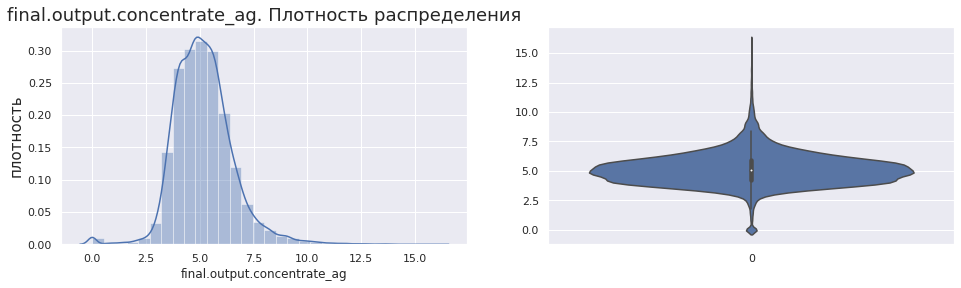

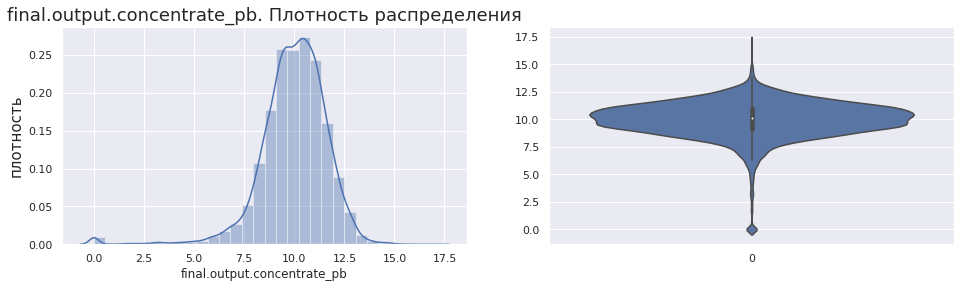

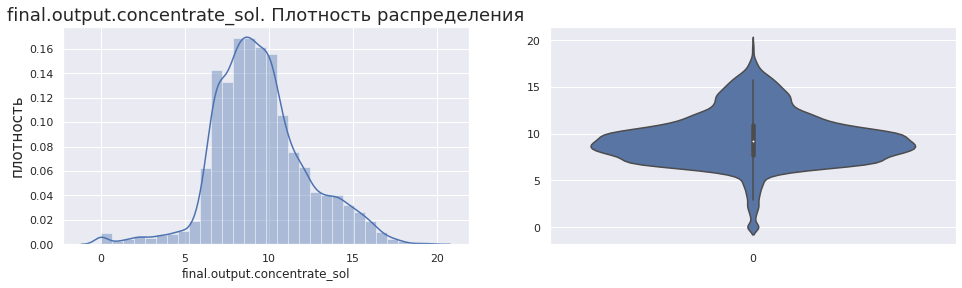

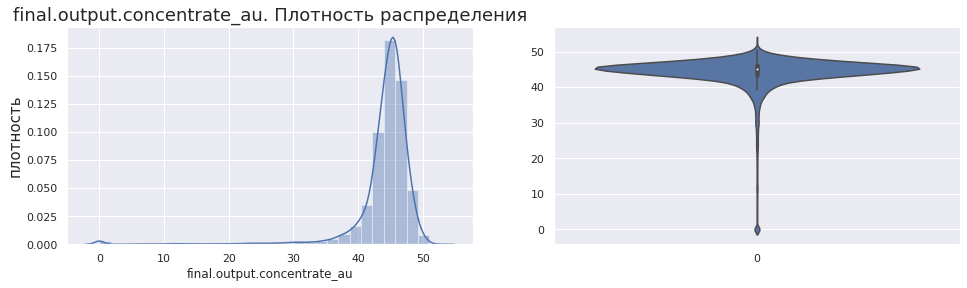

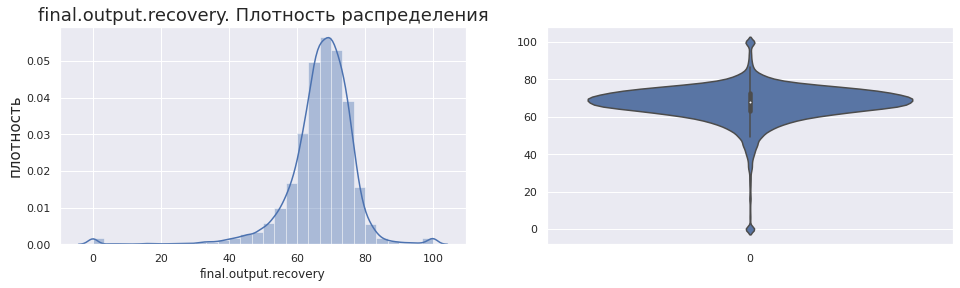

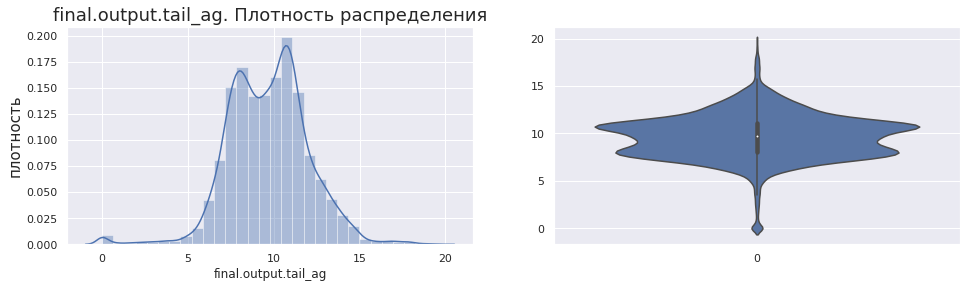

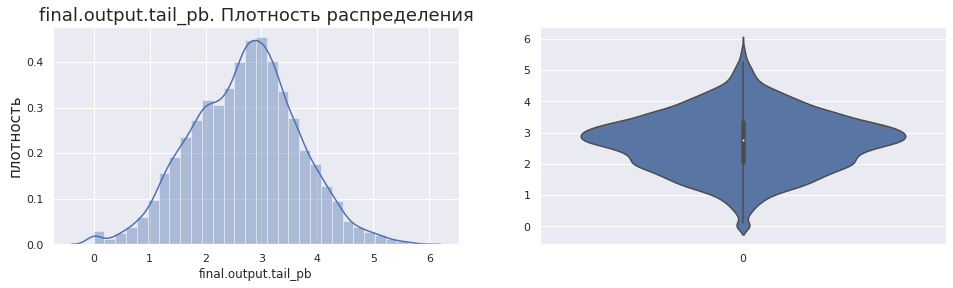

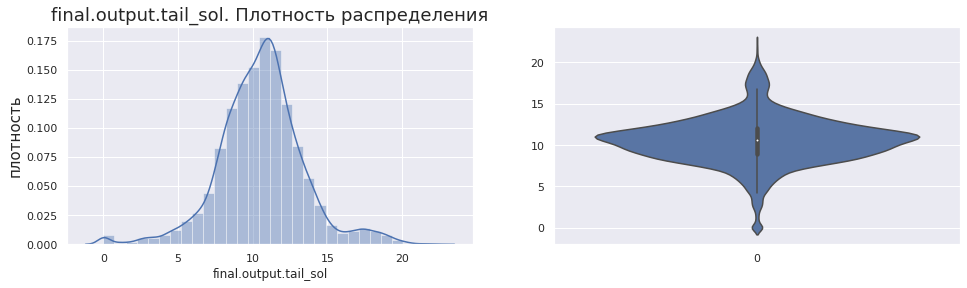

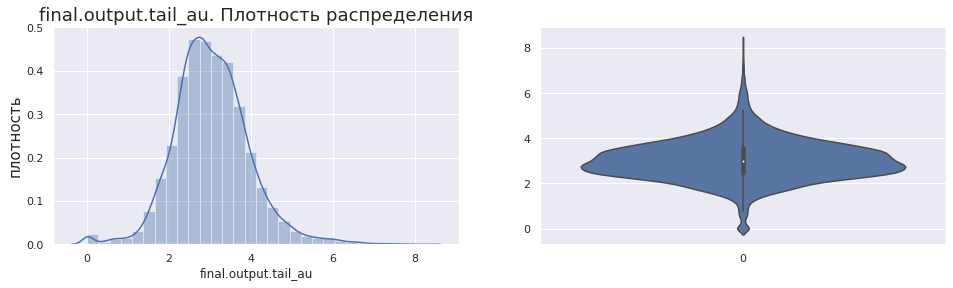

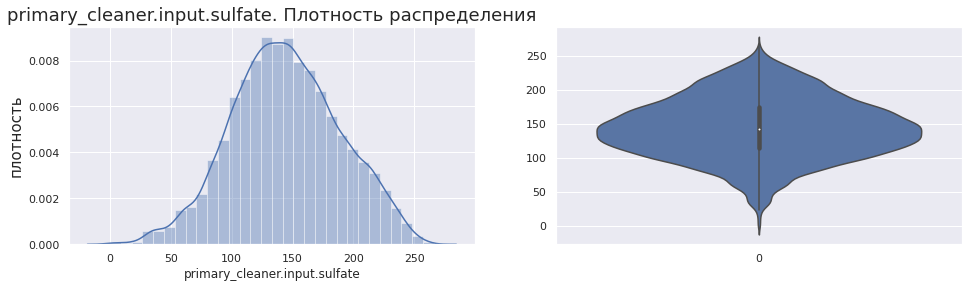

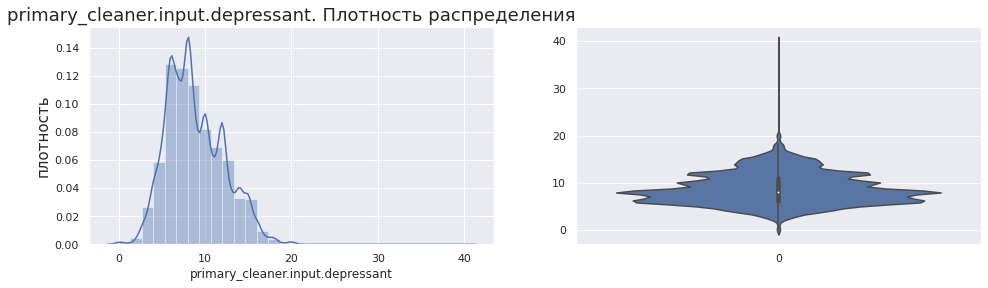

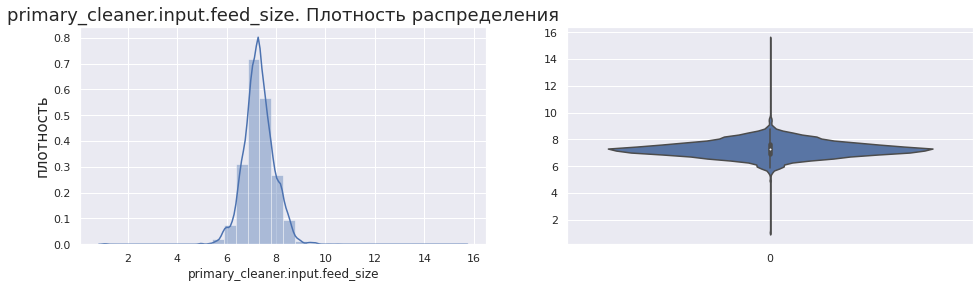

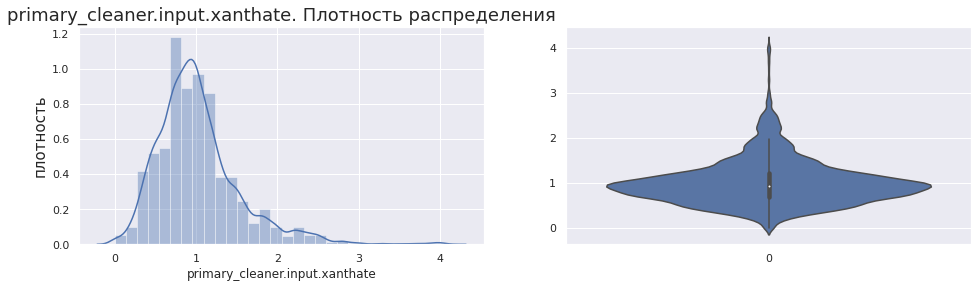

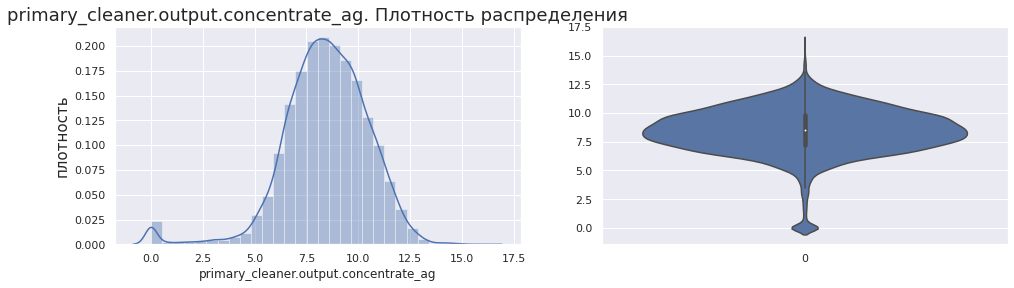

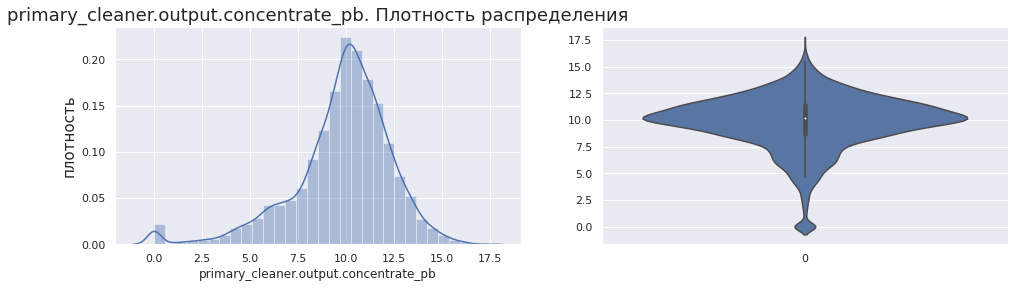

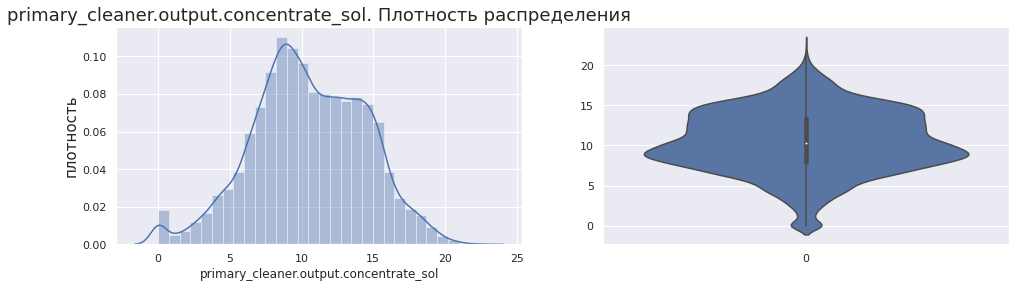

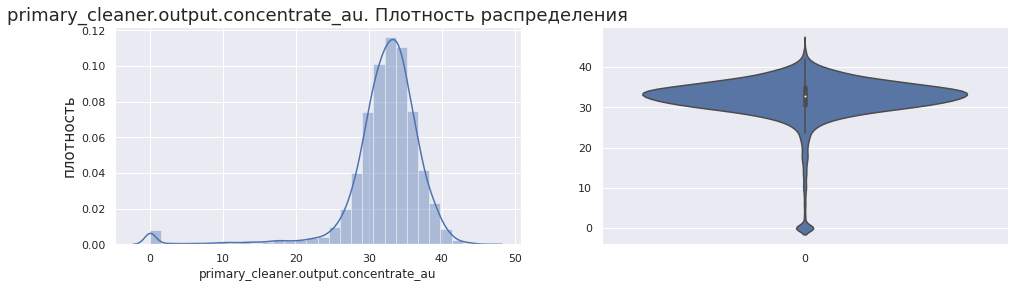

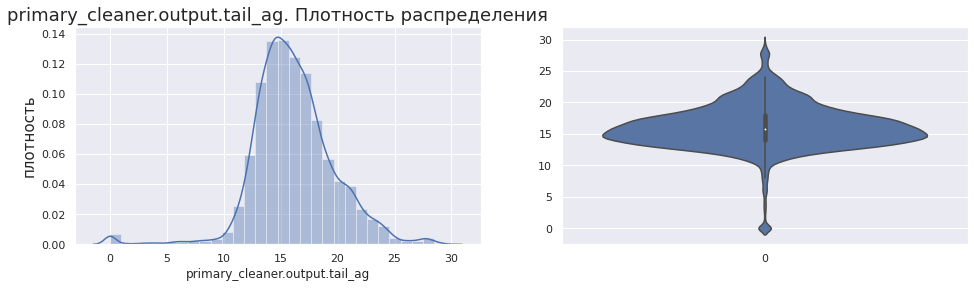

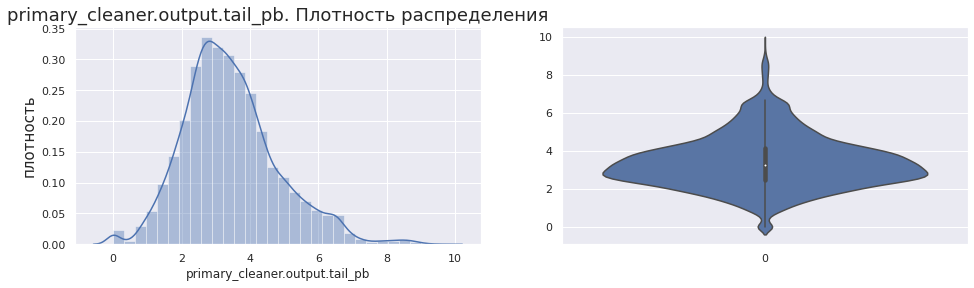

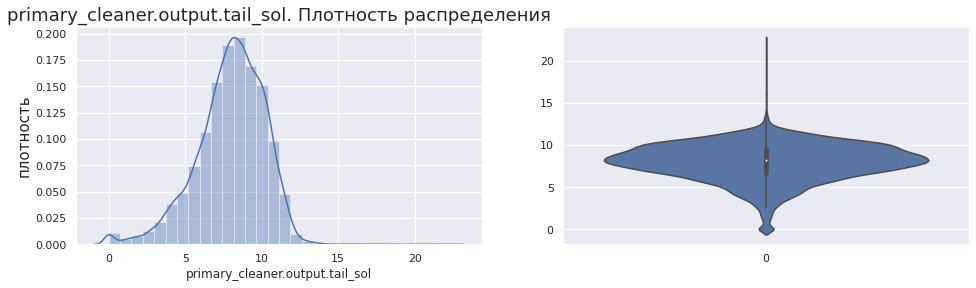

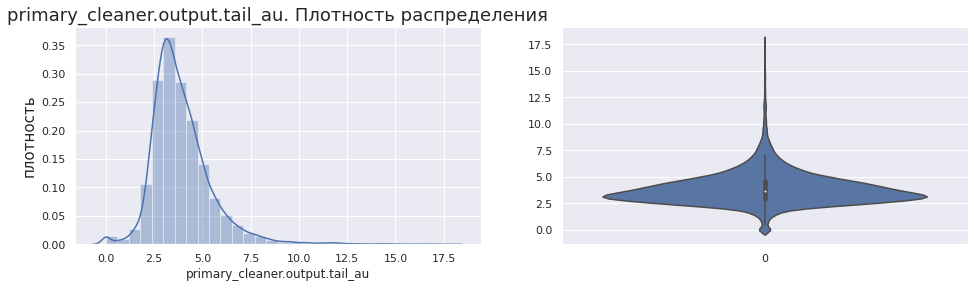

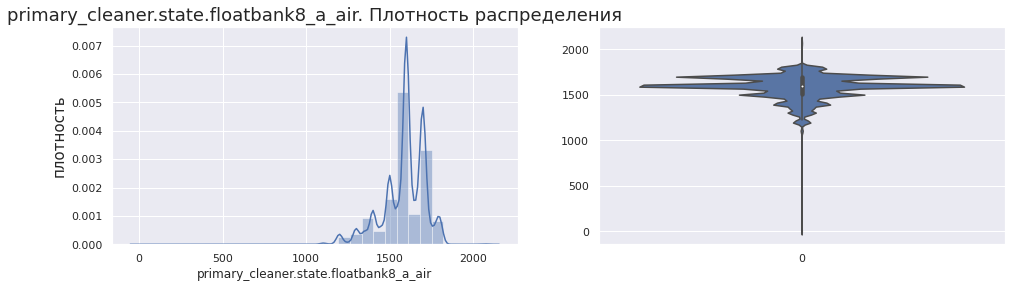

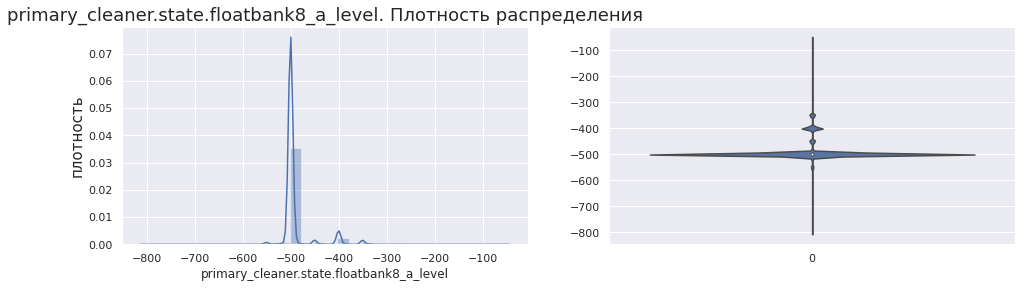

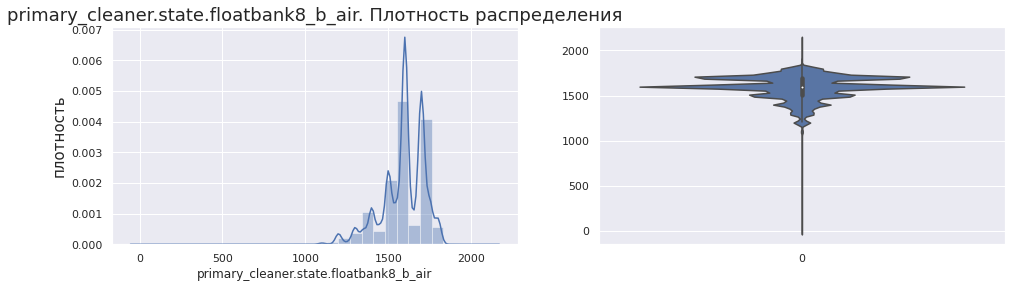

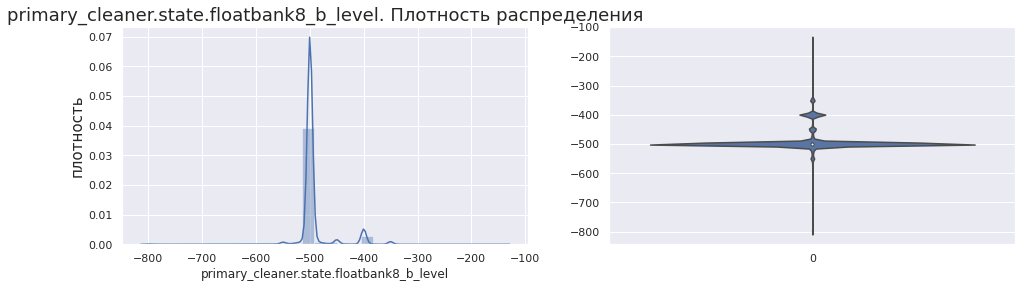

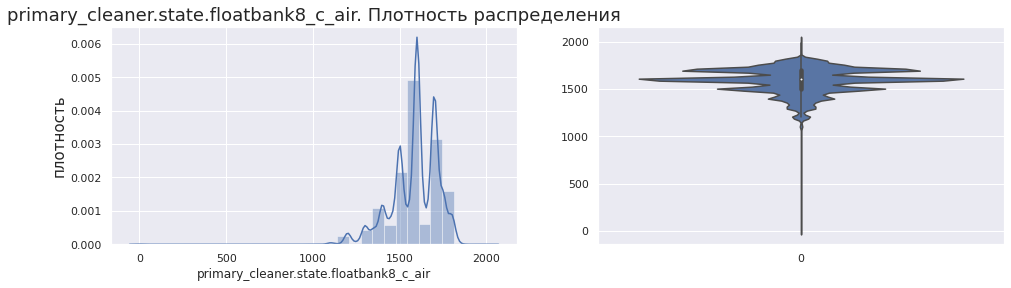

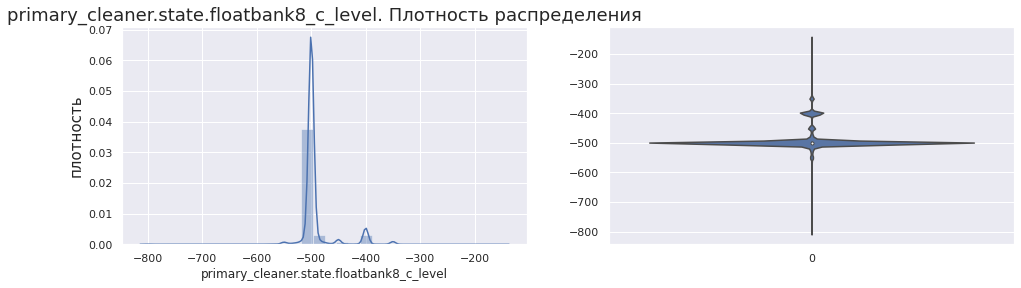

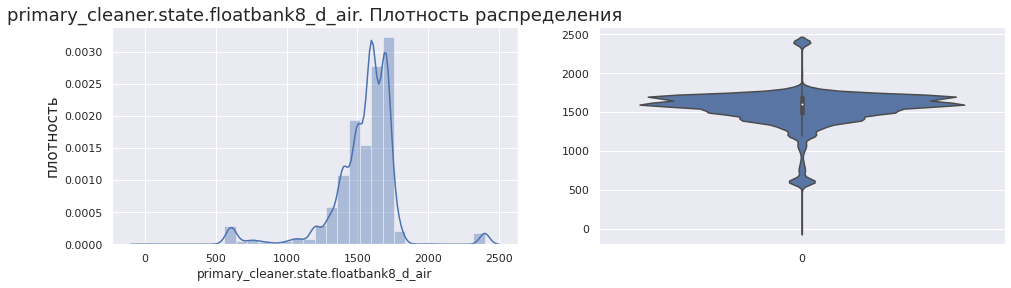

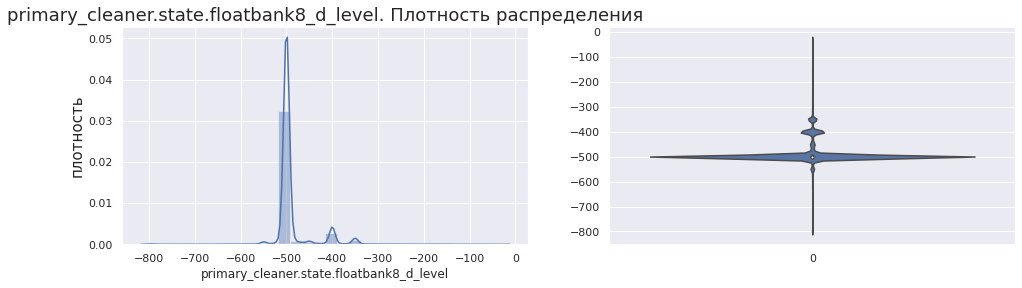

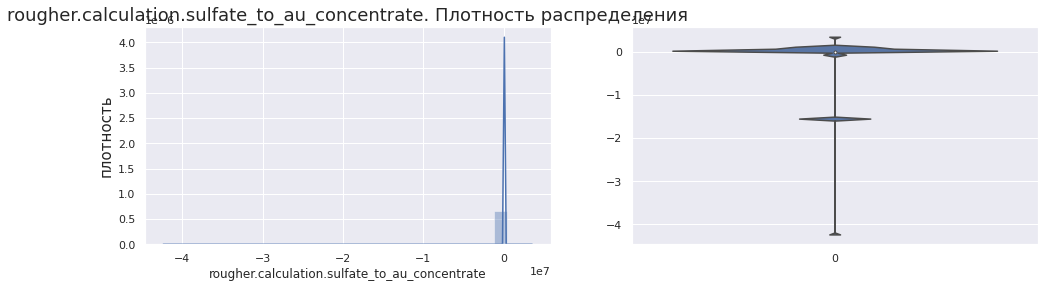

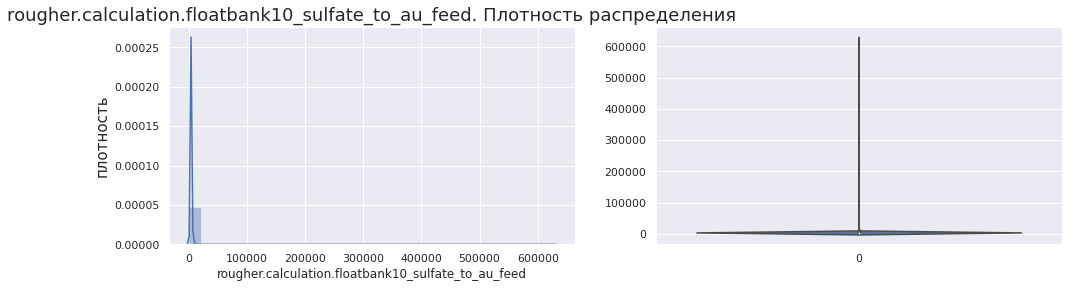

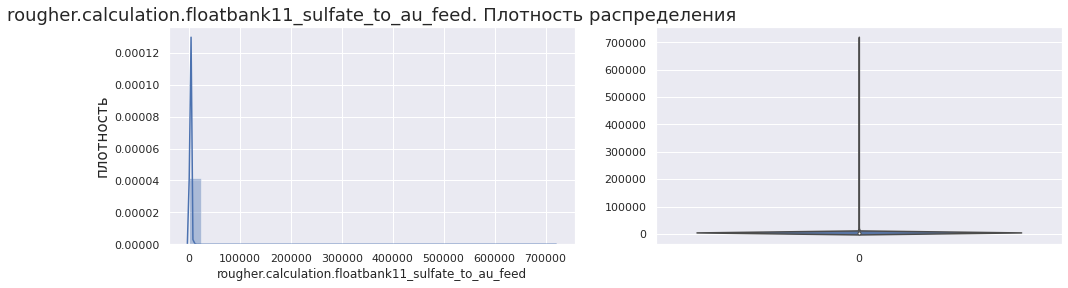

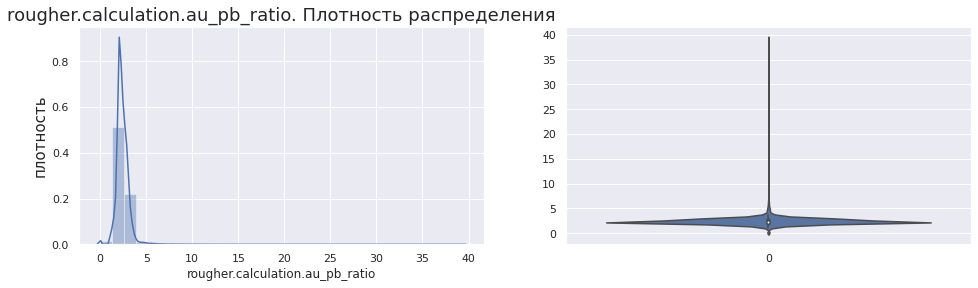

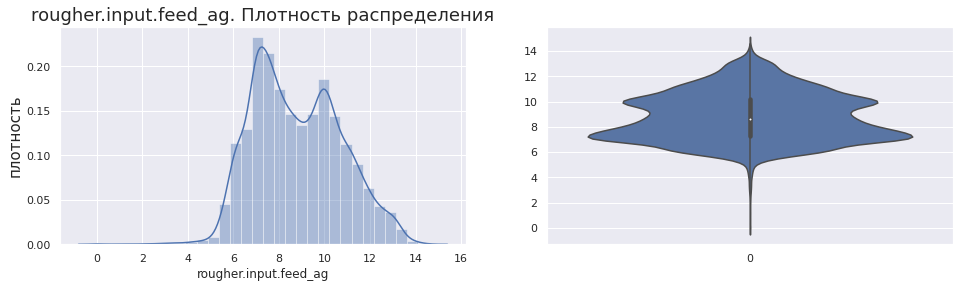

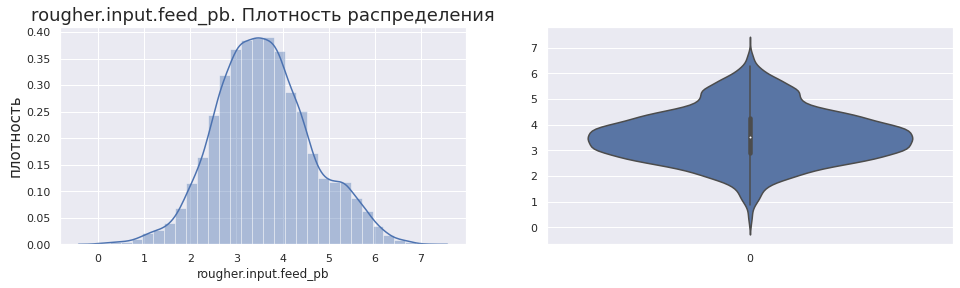

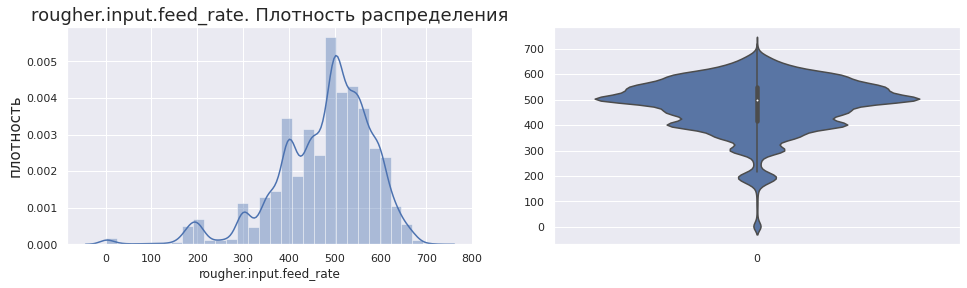

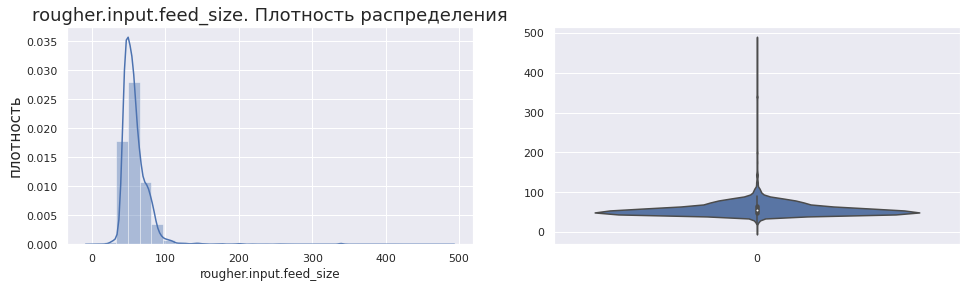

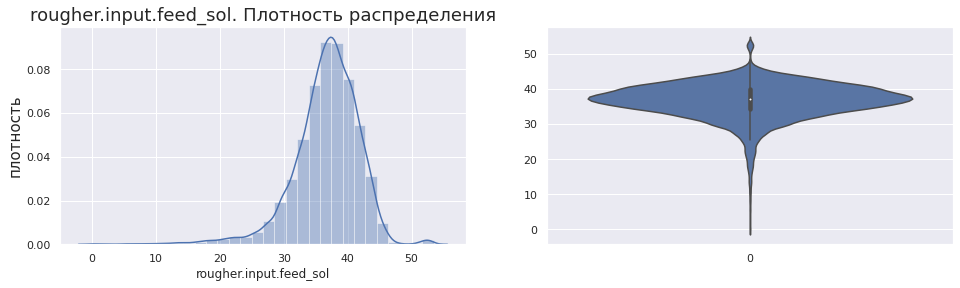

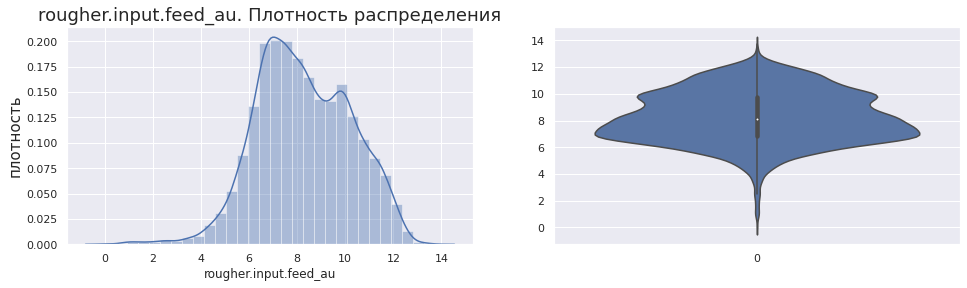

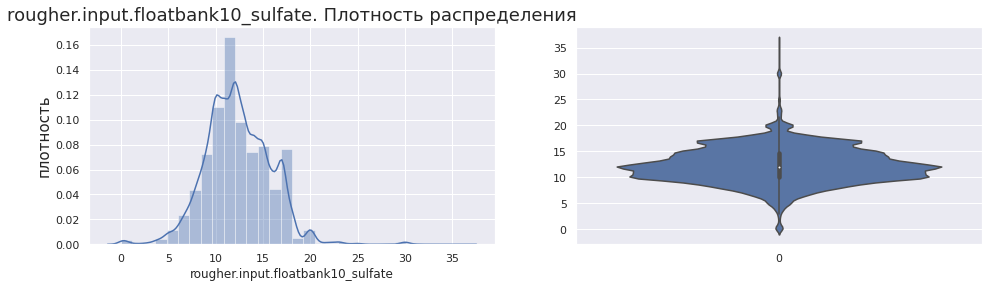

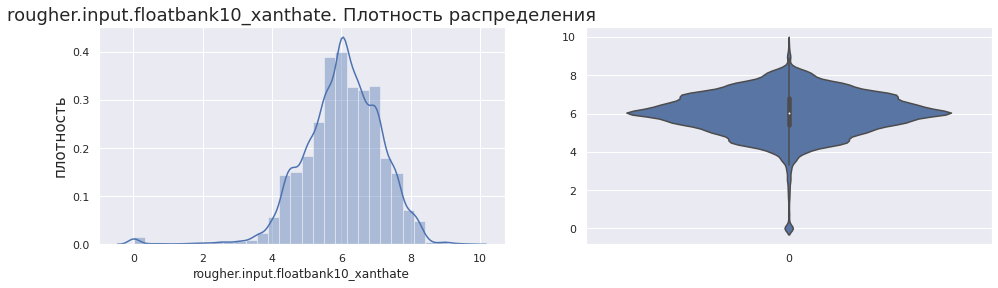

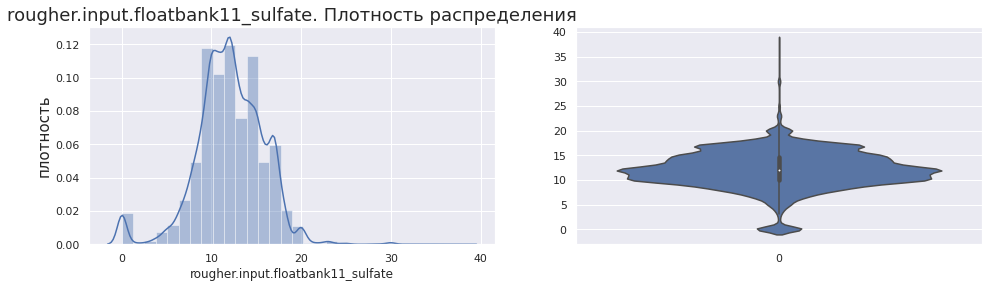

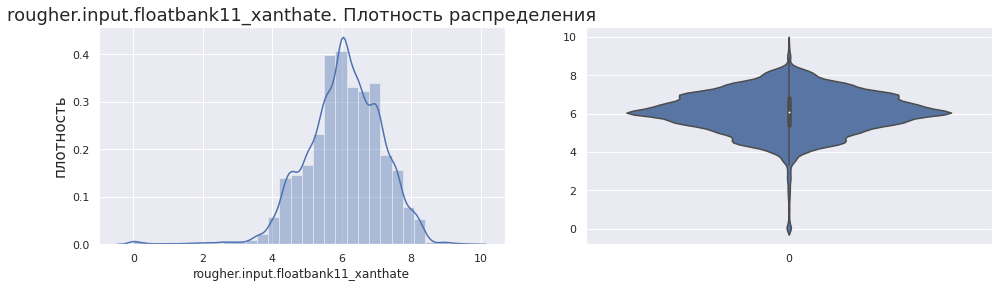

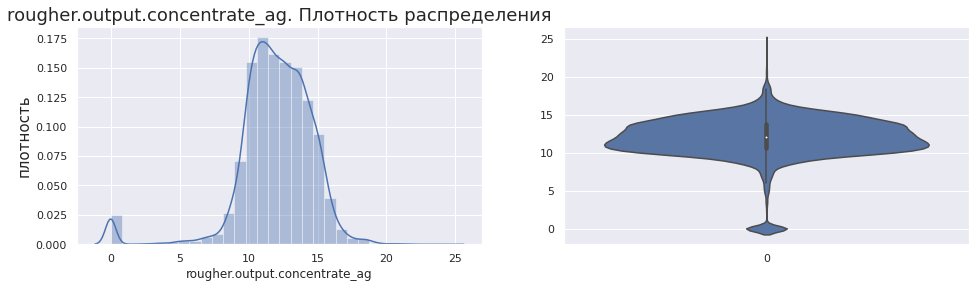

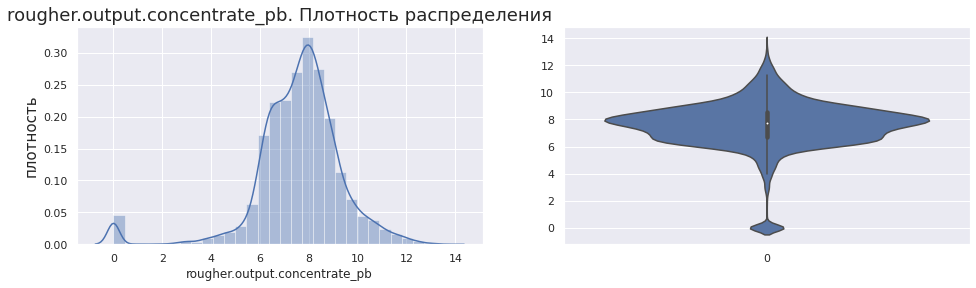

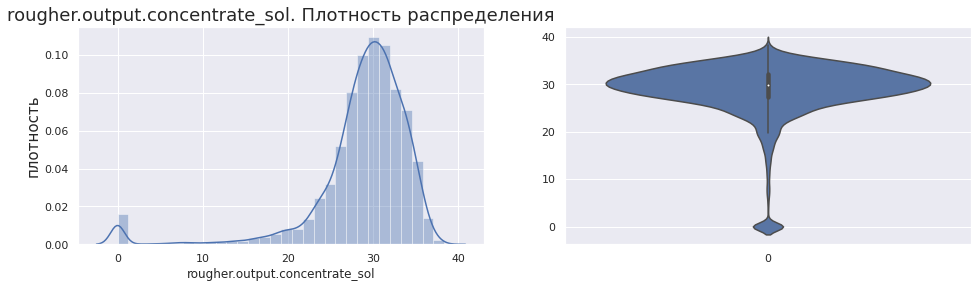

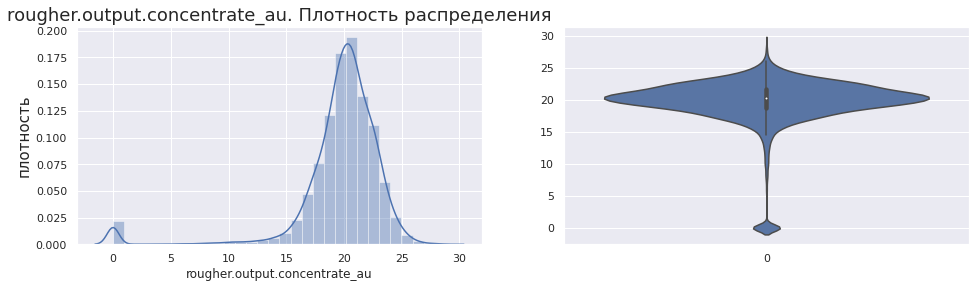

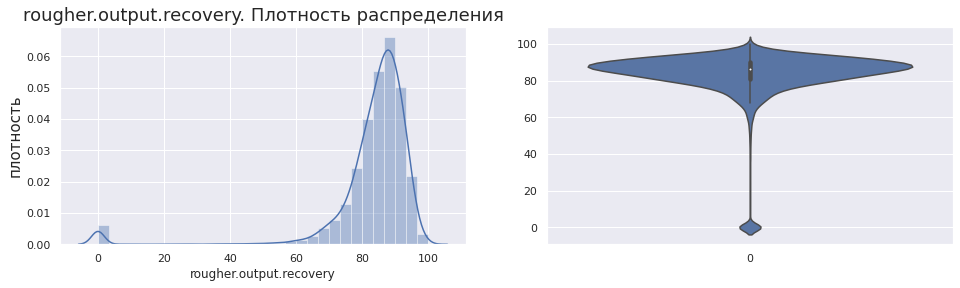

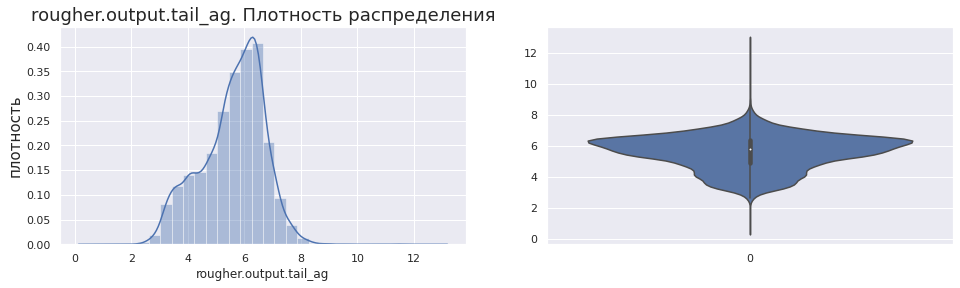

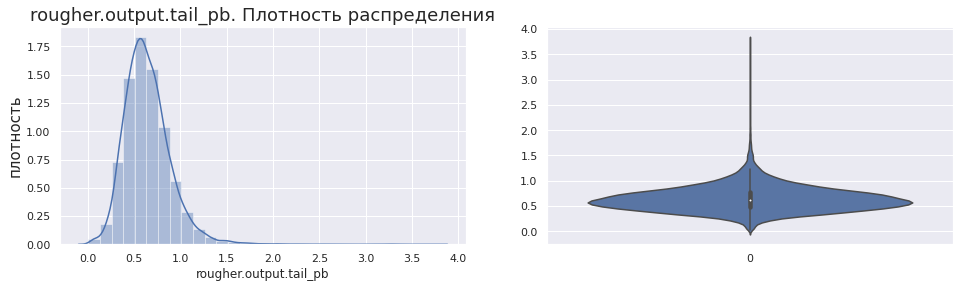

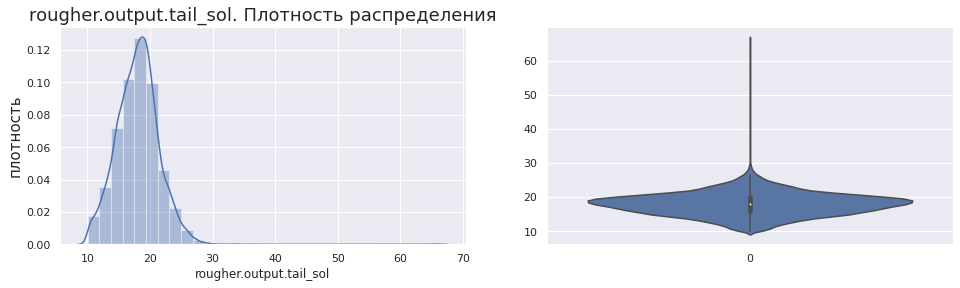

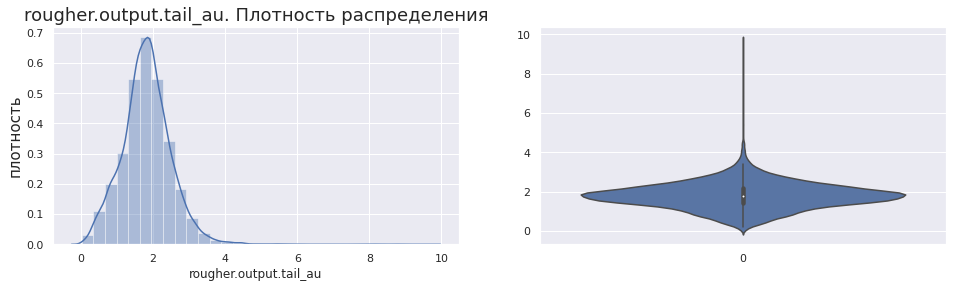

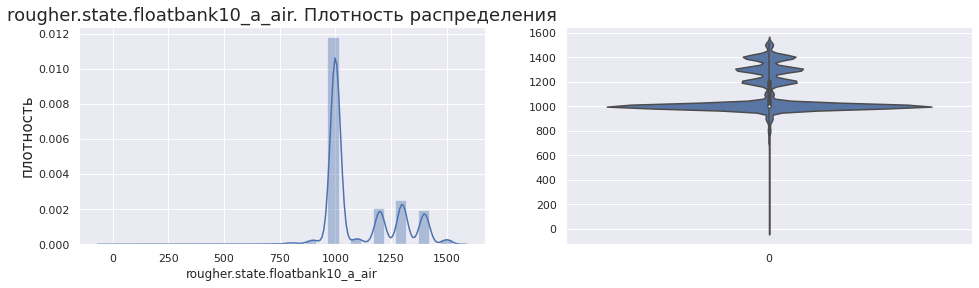

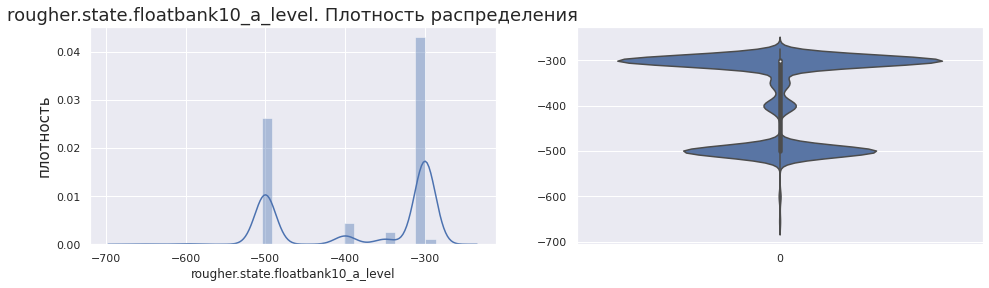

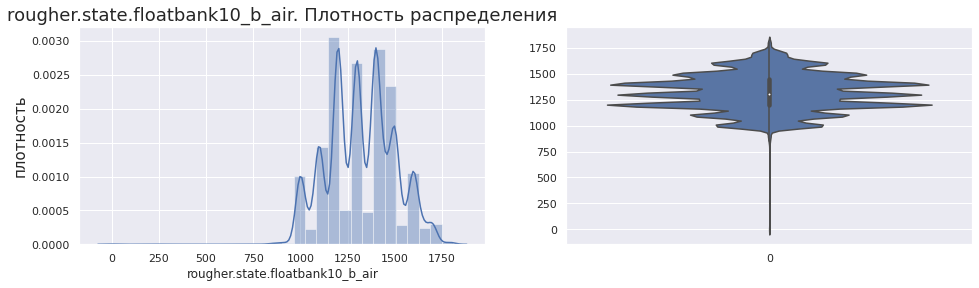

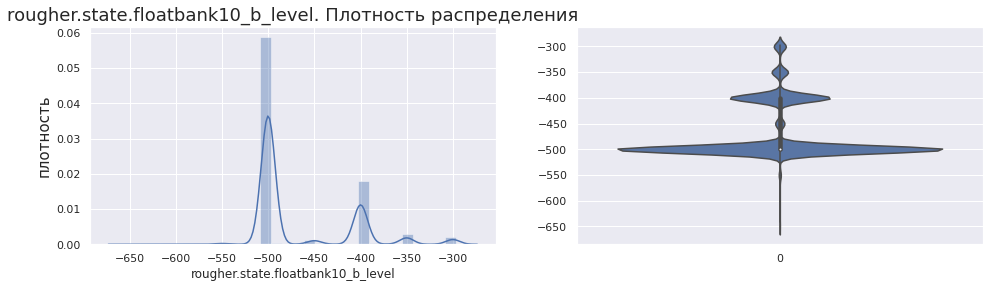

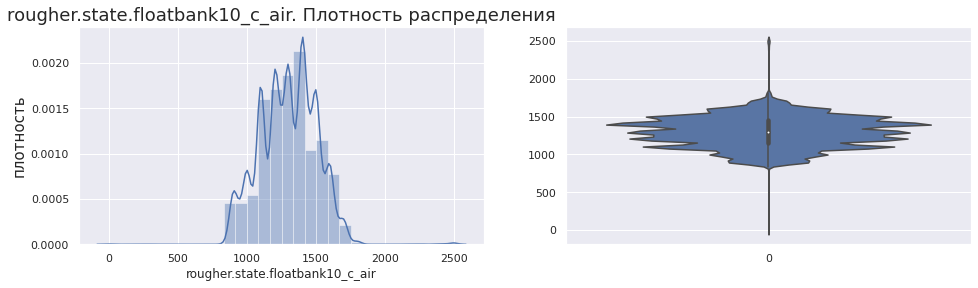

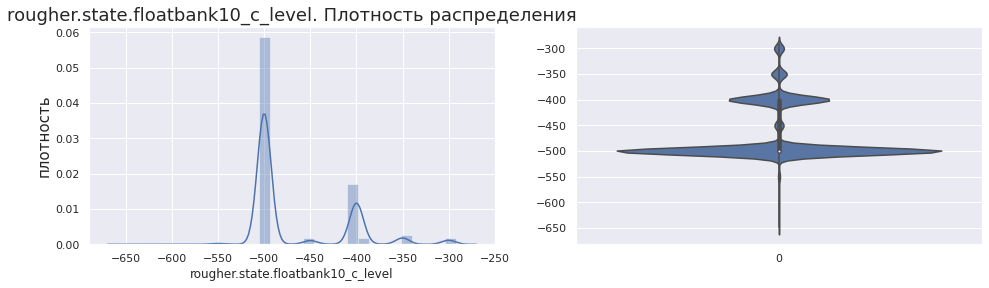

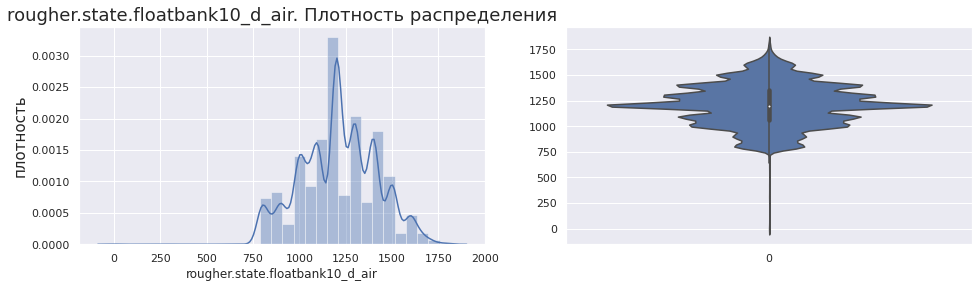

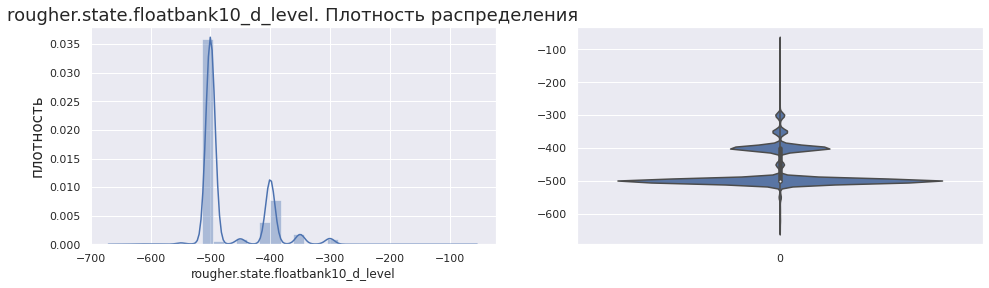

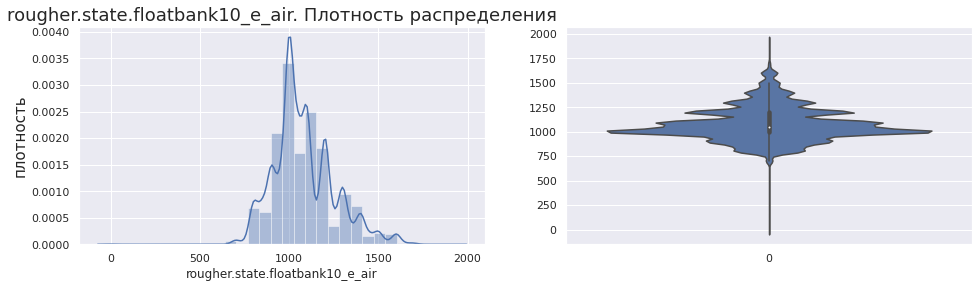

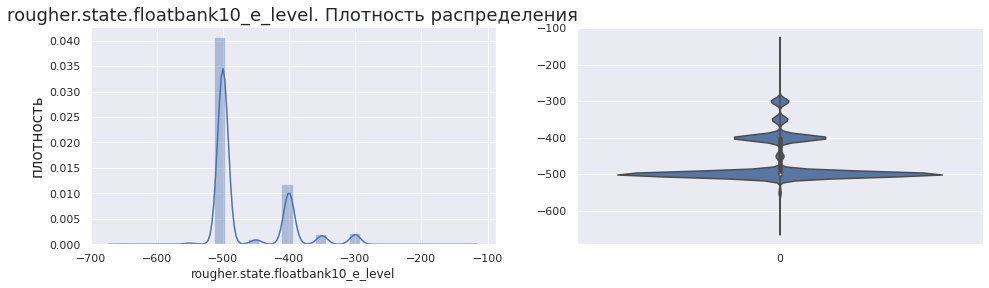

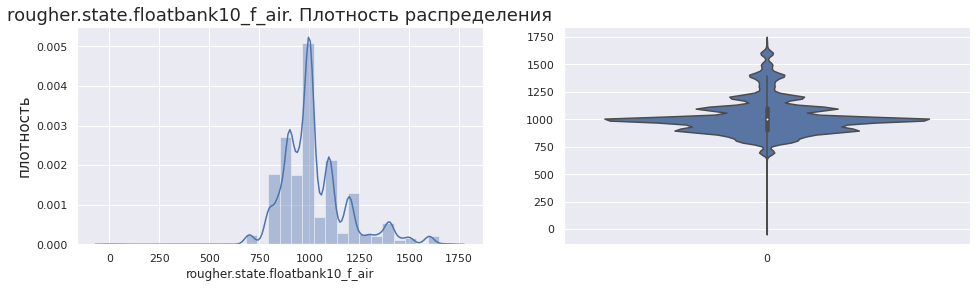

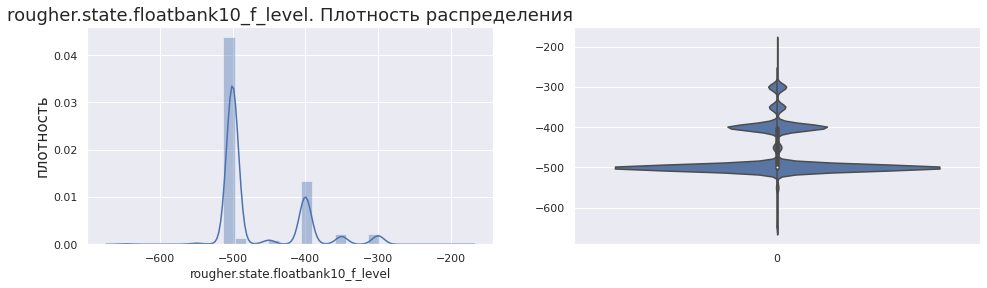

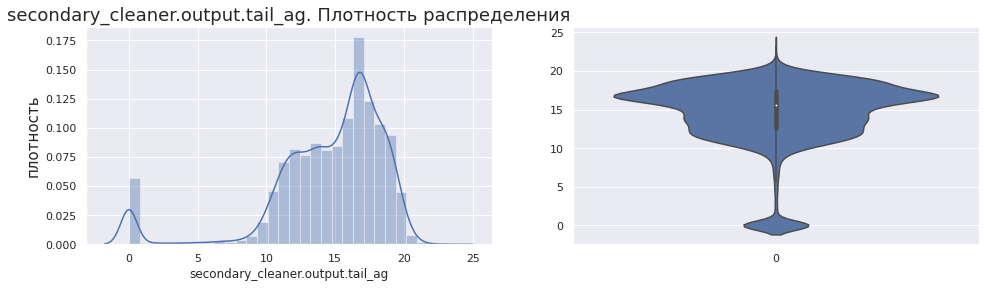

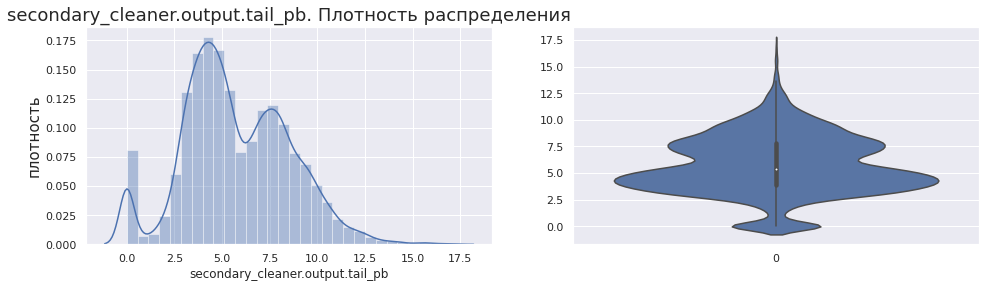

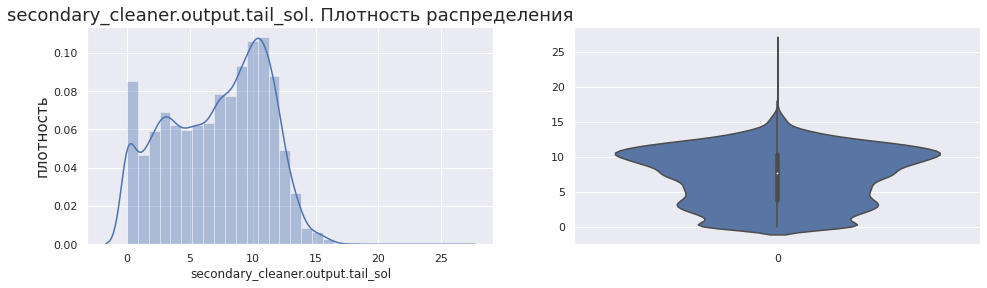

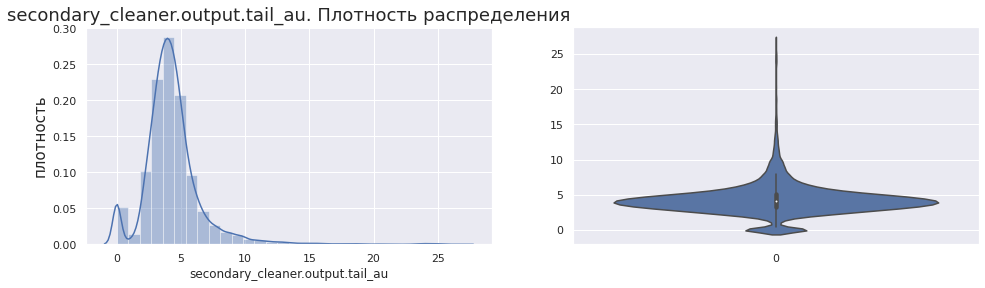

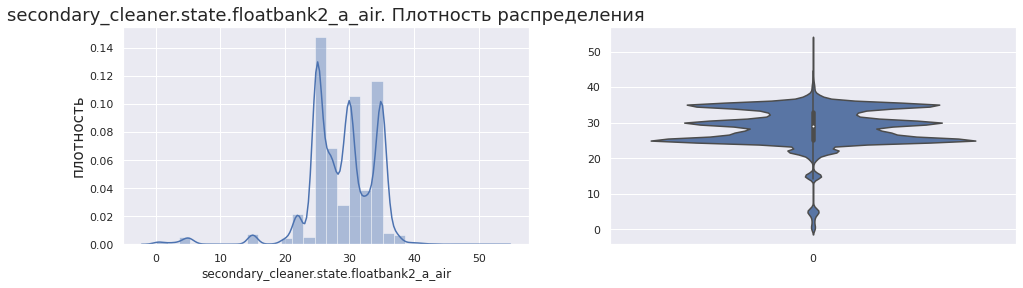

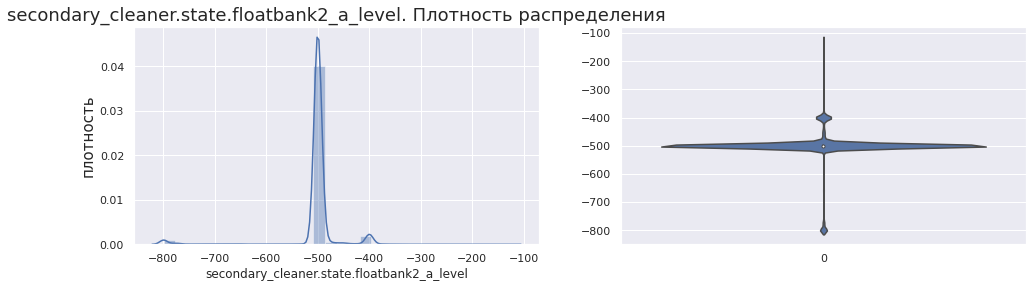

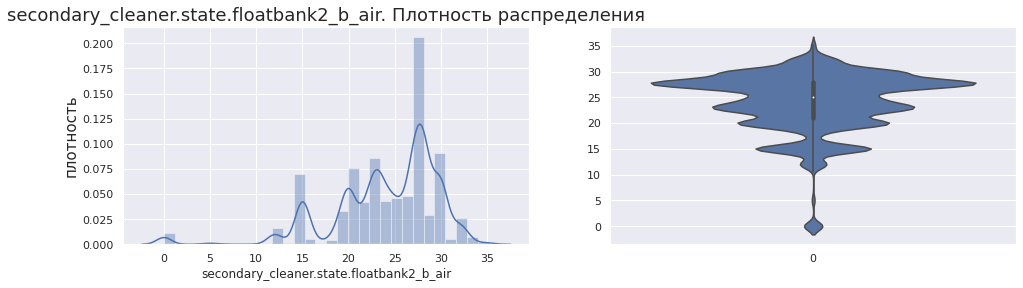

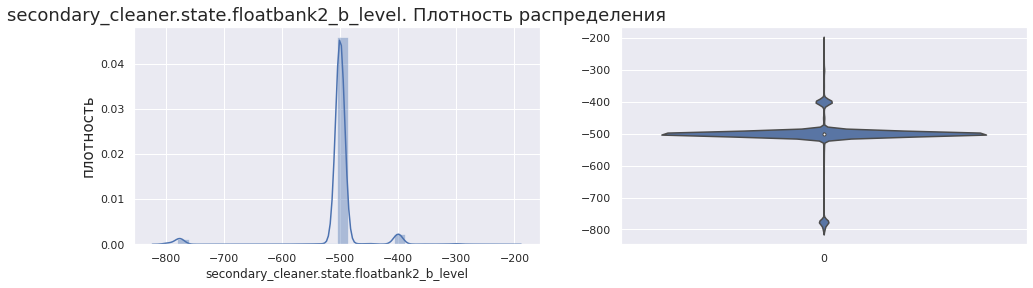

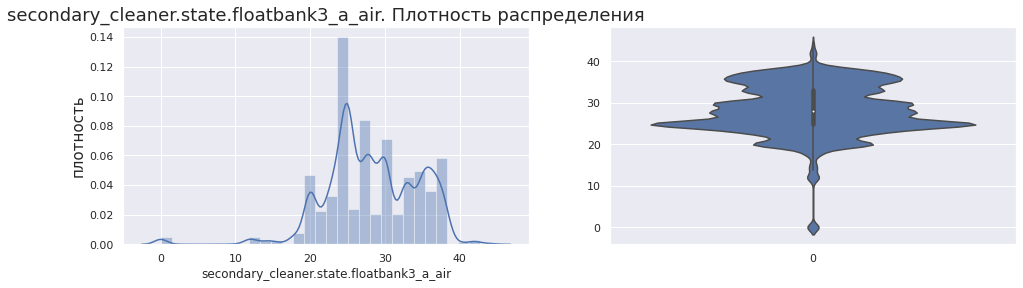

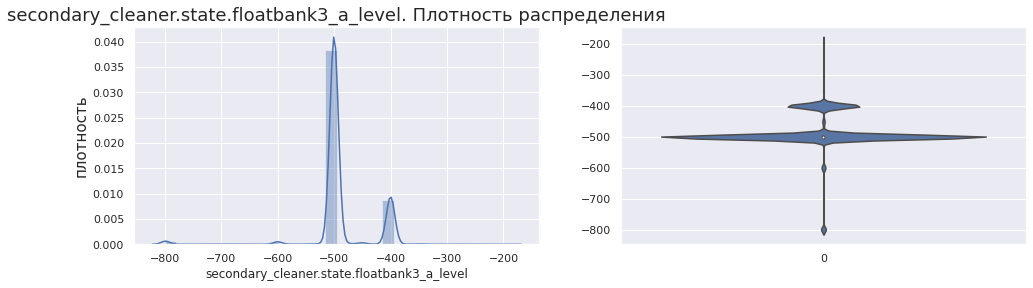

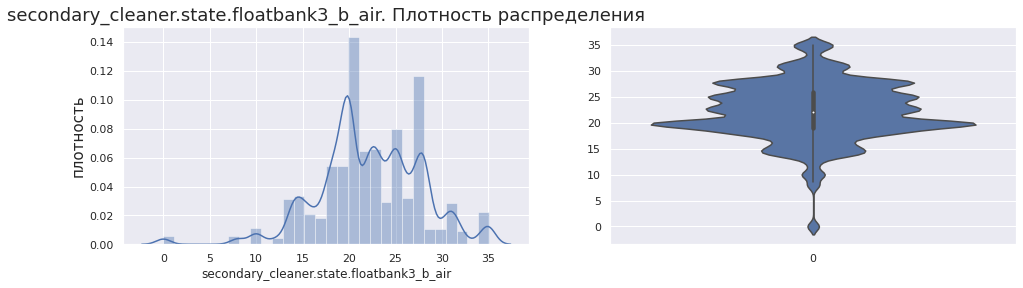

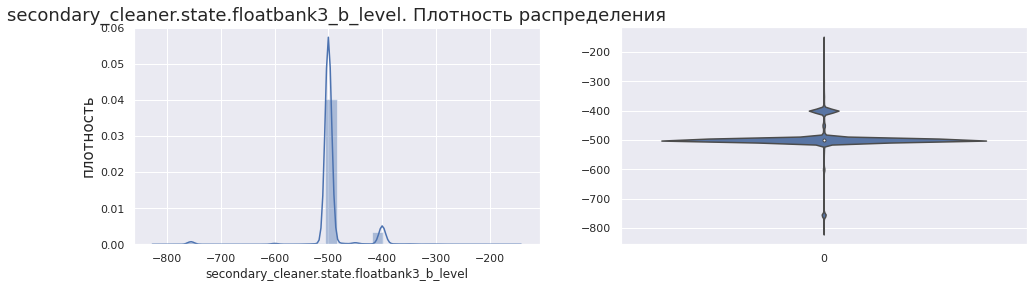

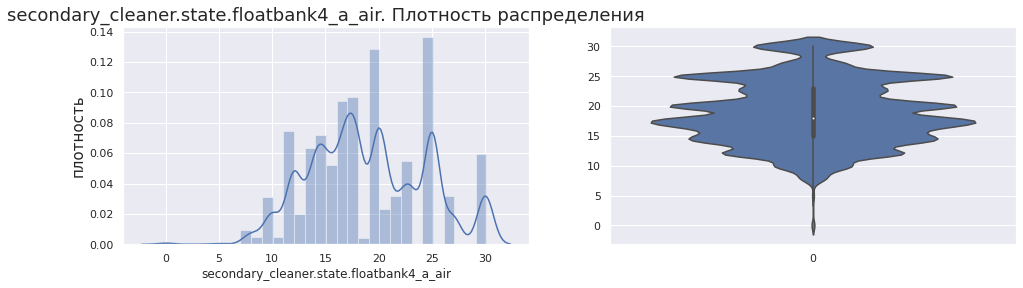

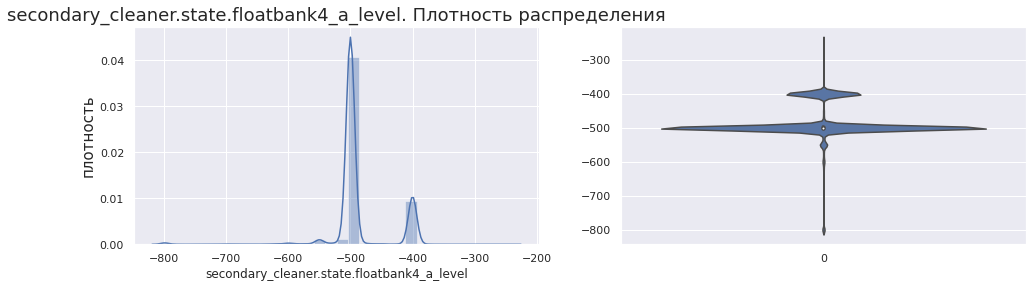

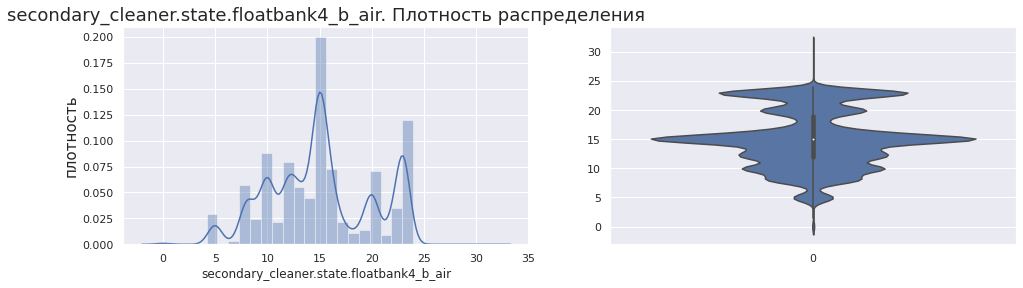

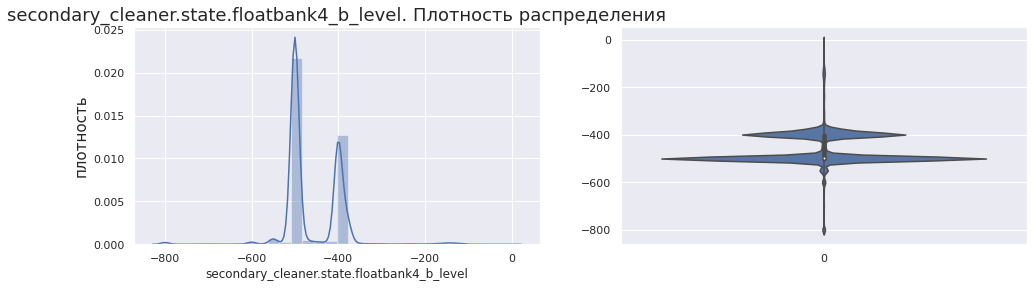

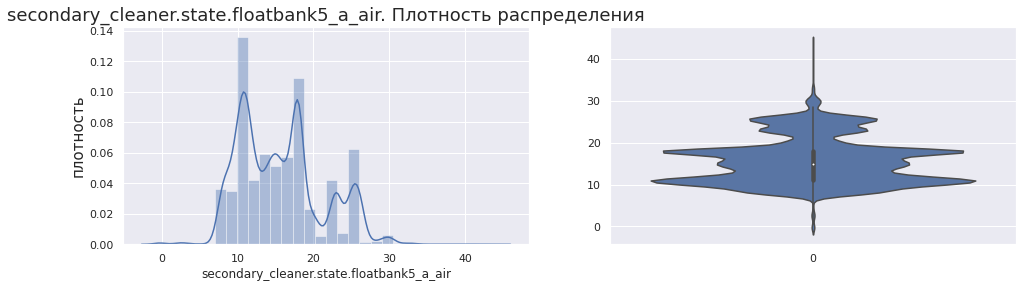

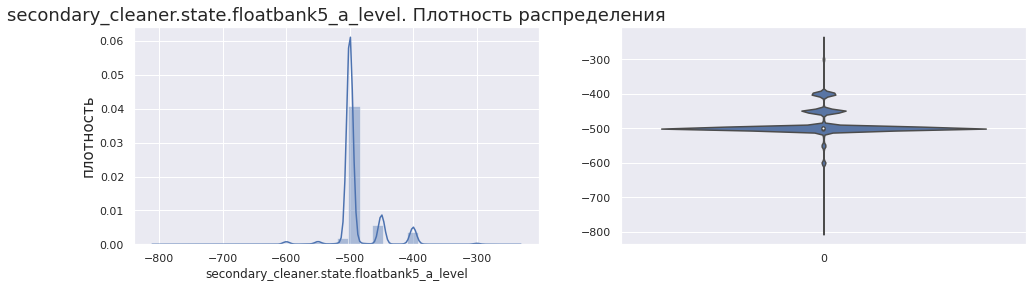

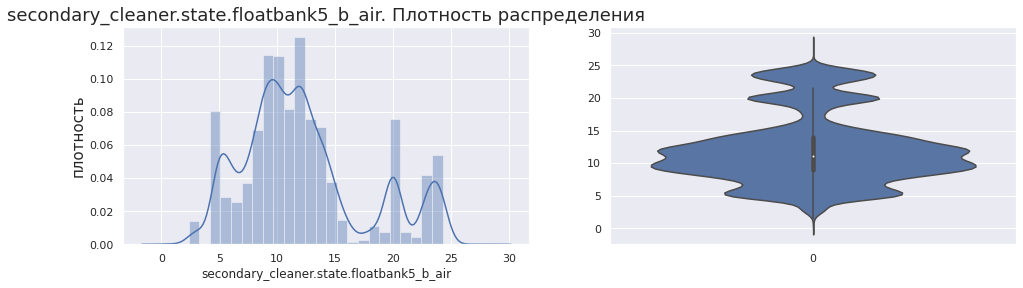

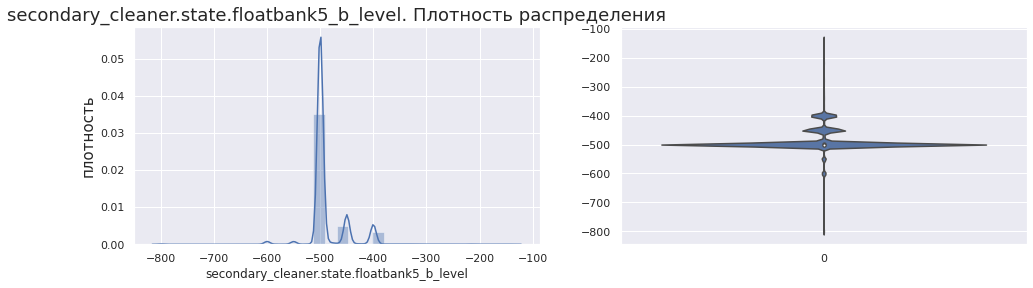

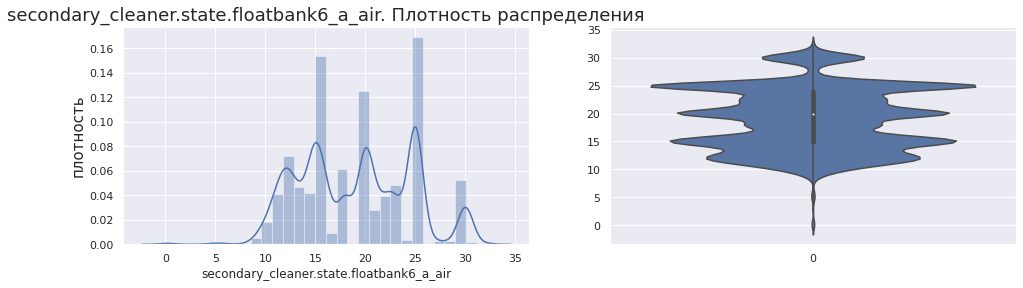

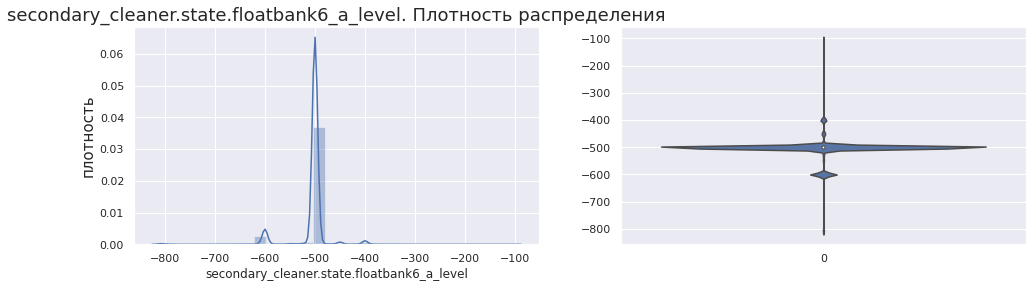

In [14]:
# define a list of columns to build histograms
for column in data_full.columns:
    show_hists(data_full[column], column, num_bins=30)

The distributions of some features differ from the normal distribution.

There are also large outliers. After feature selection, it is necessary to reduce their influence on the final model (for example, remove outliers).

The distribution scales of individual features are very different from each other (more than one order of magnitude). The selected features will need to be scaled. We will do this while building models.

**Conclusion:**

During the execution of this section, the following was determined:

   - data and data types match the description
   - no duplicates
   - there are missing values that need to be processed
   - no errors in column names
   - the ratio of test and training samples: 27.3% and 72.7%, respectively
   - the distribution of some features differs from normal, there are outliers, it is necessary to scale, since the scales of some features are very different from each other

### Verification of enrichment efficiency calculations

On this step we will verify that the enrichment efficiency is calculated correctly. For this:

1) calculate the recovery on the training sample train for the feature rougher.output.recovery (flotation stage)

2) find MAE between calculations and feature value

In [15]:
# write a function to determine recovery
def recovery(data):
    """
    Recovery calculation function
    
    C - share of gold in concentrate
    F - share of gold in raw materials before flotation/refining
    T - shares of gold in waste tailings after flotation/cleaning
    """
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    
    recovery = (((C * (F - T))) / (F * (C - T)))*100
    return recovery

In [16]:
# select columns for calculating MAE
train_rec = data_train[['rougher.output.concentrate_au', 
                    'rougher.input.feed_au', 
                    'rougher.output.tail_au',
                    'rougher.output.recovery']].copy()

train_rec = train_rec.dropna(axis=0)
train_rec['test_recovery'] = train_rec.apply(recovery, axis=1)

train_rec.head()

rougher.output.concentrate_au  rougher.input.feed_au  \
date                                                                        
2016-01-15 00:00:00                      19.793808               6.486150   
2016-01-15 01:00:00                      20.050975               6.478583   
2016-01-15 02:00:00                      19.737170               6.362222   
2016-01-15 03:00:00                      19.320810               6.118189   
2016-01-15 04:00:00                      19.216101               5.663707   

                     rougher.output.tail_au  rougher.output.recovery  \
date                                                                   
2016-01-15 00:00:00                1.170244                87.107763   
2016-01-15 01:00:00                1.184827                86.843261   
2016-01-15 02:00:00                1.162562                86.842308   
2016-01-15 03:00:00                1.079755                87.226430   
2016-01-15 04:00:00                1.012642                86.688794   

                     test_recovery  
date                                
2016-01-15 00:00:00      87.107763  
2016-01-15 01:00:00      86.843261  
2016-01-15 02:00:00      86.842308  
2016-01-15 03:00:00      87.226430  
2016-01-15 04:00:00      86.688794

In [17]:
# расчитаем МАЕ
MAE = mean_absolute_error(train_rec['rougher.output.recovery'], train_rec['test_recovery'])
print('Средняя абсолютная ошибка: {:.17f}'.format(MAE))

Средняя абсолютная ошибка: 0.00000000000000974


**Conclusion:** according to the obtained data, MAE is negligible, so this indicator is calculated correctly.

### Analysis of features not available in the test sample

Let's analyze which features are not available in the test sample and try to understand why.

In [18]:
# form a list of columns that are not in the test set
[col for col in list(data_train.columns) if (col not in list(data_test.columns))]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**Conclusion:**

1) In the test sample, there are no output parameters of the output product at each stage of the technical process. These are concentrates and tailings for metals (Au, Ag, Pb) and salts, as well as calculated recovery at different stages. But these data are not suitable for training the model, as they appear during or after the measurement of the target features.

2) Also in the test sample, there are no calculated signs at the rougher.calculation stage of flotation (concentration of sulfates relative to gold, ratio of gold and lead, etc.). These features will also not participate in the construction of the model.

### Data preprocessing

In this section, we will focus on missing values and data types. Let's display once again the general information and information about missing values for all data sets

In [19]:
# write a function to count the number of missing values and the percentage
def missing_values_percentage(df):
    """
    Function to count the number of gaps and the percentage
    """
    count=round(df.isnull().sum(),2)
    percent=round((df.isnull().sum()/df.shape[0])*100,2)
    data=pd.concat([count,percent],axis=1)
    data.reset_index(inplace=True)
    data.rename(columns={0: 'Missing Values Count',1: 'Missing Values %'},inplace=True)
    display(data[data['Missing Values Count']!=0].sort_values(by = 'Missing Values %', ascending = False))

Output information on the training sample

In [20]:
# percentage of missing values
missing_values_percentage(data_train)

index  Missing Values Count  \
66           secondary_cleaner.output.tail_sol                  1605   
60             rougher.state.floatbank10_e_air                   436   
42          rougher.input.floatbank11_xanthate                   428   
15      primary_cleaner.output.concentrate_sol                   286   
68    secondary_cleaner.state.floatbank2_a_air                   217   
..                                         ...                   ...   
53           rougher.state.floatbank10_a_level                     1   
54             rougher.state.floatbank10_b_air                     1   
55           rougher.state.floatbank10_b_level                     1   
56             rougher.state.floatbank10_c_air                     1   
85  secondary_cleaner.state.floatbank6_a_level                     1   

    Missing Values %  
66             11.34  
60              3.08  
42              3.02  
15              2.02  
68              1.53  
..               ...  
53              0.01  
54              0.01  
55              0.01  
56              0.01  
85              0.01  

[62 rows x 3 columns]

In [21]:
# determine the presence of missing values in the target values
data_train[['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

Based on the data obtained above, we can draw the following conclusions on data_train:

- then in most columns the missing values are small from 1% to 3%, but in the column secondary_cleaher.output.tail_sal the percentage of missing values is 11.

All these signs can be replaced by the ffill method, since we know that values close in date will be equal. In this case, we believe that this is the most correct strategy for dealing with gaps. There are no missing values in the target values.

We will display information on the test sample

In [22]:
# percentage of missing values
missing_values_percentage(data_test)

index  Missing Values Count  \
21        rougher.input.floatbank11_xanthate                    25   
16                    rougher.input.feed_sol                    21   
38  secondary_cleaner.state.floatbank3_a_air                     9   
20         rougher.input.floatbank11_sulfate                     8   
1           primary_cleaner.input.depressant                     5   
18         rougher.input.floatbank10_sulfate                     5   
0              primary_cleaner.input.sulfate                     4   
3             primary_cleaner.input.xanthate                     4   
14                   rougher.input.feed_rate                     3   
34  secondary_cleaner.state.floatbank2_a_air                     3   
36  secondary_cleaner.state.floatbank2_b_air                     2   
15                   rougher.input.feed_size                     1   

    Missing Values %  
21              0.47  
16              0.40  
38              0.17  
20              0.15  
1               0.09  
18              0.09  
0               0.08  
3               0.08  
14              0.06  
34              0.06  
36              0.04  
15              0.02

Based on the data obtained above, we can draw the following conclusions on data_test:

- a small number of missing values less than 0.5%

We will display information on the full sample

In [23]:
# percentage of missing values
missing_values_percentage(data_full)

index  Missing Values Count  \
66           secondary_cleaner.output.tail_sol                  1748   
42          rougher.input.floatbank11_xanthate                   453   
60             rougher.state.floatbank10_e_air                   436   
15      primary_cleaner.output.concentrate_sol                   370   
68    secondary_cleaner.state.floatbank2_a_air                   220   
..                                         ...                   ...   
53           rougher.state.floatbank10_a_level                     1   
54             rougher.state.floatbank10_b_air                     1   
55           rougher.state.floatbank10_b_level                     1   
56             rougher.state.floatbank10_c_air                     1   
85  secondary_cleaner.state.floatbank6_a_level                     1   

    Missing Values %  
66              8.99  
42              2.33  
60              2.24  
15              1.90  
68              1.13  
..               ...  
53              0.01  
54              0.01  
55              0.01  
56              0.01  
85              0.01  

[63 rows x 3 columns]

In [24]:
# determine the presence of missing values in the target values
data_full[['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

Based on the data obtained above, we have the following conclusions on data_full:

- in most columns the missing values are small from 1% to 3%, but in the column secondary_cleaher.output.tail_sal the percentage of gaps is 9.

All these missing values can be replaced by the ffill method, since we know that values close in date will be equal. In this case, we believe that this is the most correct strategy for dealing with gaps. There are no missing values in the target values.

Fill in the missing values with the ffill method

In [25]:
# fill in the missing values in data_train
data_train.fillna(method='ffill', inplace=True)

In [26]:
# fill in the missing values in data_test
data_test.fillna(method='ffill', inplace=True)

In [27]:
# fill in the missing values in data_full
data_full.fillna(method='ffill', inplace=True)

All missing values have been processed. Let's add target features to the test set, which we will take from the full data set.

In [28]:
# adding target features to the test dataset
data_test = data_test.join(data_full[['rougher.output.recovery', 'final.output.recovery']])

In [46]:
data_test 

primary_cleaner.input.sulfate  \
date                                                 
2016-09-01 00:59:59                     210.800909   
2016-09-01 01:59:59                     215.392455   
2016-09-01 02:59:59                     215.259946   
2016-09-01 03:59:59                     215.336236   
2016-09-01 04:59:59                     199.099327   
...                                            ...   
2017-12-31 19:59:59                     173.957757   
2017-12-31 20:59:59                     172.910270   
2017-12-31 21:59:59                     171.135718   
2017-12-31 22:59:59                     179.697158   
2017-12-31 23:59:59                     181.556856   

                     primary_cleaner.input.depressant  \
date                                                    
2016-09-01 00:59:59                         14.993118   
2016-09-01 01:59:59                         14.987471   
2016-09-01 02:59:59                         12.884934   
2016-09-01 03:59:59                         12.006805   
2016-09-01 04:59:59                         10.682530   
...                                               ...   
2017-12-31 19:59:59                         15.963399   
2017-12-31 20:59:59                         16.002605   
2017-12-31 21:59:59                         15.993669   
2017-12-31 22:59:59                         15.438979   
2017-12-31 23:59:59                         14.995850   

                     primary_cleaner.input.feed_size  \
date                                                   
2016-09-01 00:59:59                         8.080000   
2016-09-01 01:59:59                         8.080000   
2016-09-01 02:59:59                         7.786667   
2016-09-01 03:59:59                         7.640000   
2016-09-01 04:59:59                         7.530000   
...                                              ...   
2017-12-31 19:59:59                         8.070000   
2017-12-31 20:59:59                         8.070000   
2017-12-31 21:59:59                         8.070000   
2017-12-31 22:59:59                         8.070000   
2017-12-31 23:59:59                         8.070000   

                     primary_cleaner.input.xanthate  \
date                                                  
2016-09-01 00:59:59                        1.005021   
2016-09-01 01:59:59                        0.990469   
2016-09-01 02:59:59                        0.996043   
2016-09-01 03:59:59                        0.863514   
2016-09-01 04:59:59                        0.805575   
...                                             ...   
2017-12-31 19:59:59                        0.896701   
2017-12-31 20:59:59                        0.896519   
2017-12-31 21:59:59                        1.165996   
2017-12-31 22:59:59                        1.501068   
2017-12-31 23:59:59                        1.623454   

                     primary_cleaner.state.floatbank8_a_air  \
date                                                          
2016-09-01 00:59:59                             1398.981301   
2016-09-01 01:59:59                             1398.777912   
2016-09-01 02:59:59                             1398.493666   
2016-09-01 03:59:59                             1399.618111   
2016-09-01 04:59:59                             1401.268123   
...                                                     ...   
2017-12-31 19:59:59                             1401.930554   
2017-12-31 20:59:59                             1447.075722   
2017-12-31 21:59:59                             1498.836182   
2017-12-31 22:59:59                             1498.466243   
2017-12-31 23:59:59                             1498.096303   

                     primary_cleaner.state.floatbank8_a_level  \
date                                                            
2016-09-01 00:59:59                               -500.225577   
2016-09-01 01:59:59                               -500.057435   
2016-09-01 02:59:59                               -

In [29]:
# examination
print(data_test.loc['2016-09-01 01:59:59'][['final.output.recovery']])
print(data_full.loc['2016-09-01 01:59:59'][['final.output.recovery']])

final.output.recovery    68.910432
Name: 2016-09-01 01:59:59, dtype: float64
final.output.recovery    68.910432
Name: 2016-09-01 01:59:59, dtype: float64


**Conclusion:**

During the data preprocessing were:

1) filled missing values in all datasets with the ffill method

2) add target features to the test set

### Conclusion

During this step, the following was determined:

   - data and data types match the description
   - no duplicates
   - there are missing values that need to be processed
   - no errors in column names
   - the ratio of test and training samples: 27.3% and 72.7%, respectively
   - the distribution of some features differs from the normal, there are outliers, it is necessary to scale, since the scales of some features are very different from each other
   - MAE is equal to 9.7 * 10e-15, this indicator is negligible, so the calculations are correct
   - in the test sample, there are no output parameters of the product at each stage of the technical process, and calculated signs at each stage of flotation
   - at the preprocessing stage, the missing values were filled in, and target features were added to the test sample.

## Data analysis

In this section, the following steps will be performed:

   1 analysis of changes in the concentration of metals (Au, Ag, Pb)
    
   2 Comparison of the size distribution of raw material granules
    
   3 study of the total concentrations of substances depending on the stage of processing (in raw materials, in rough and final concentrates)

### Analysis of changes in the concentration of metals (Au, Ag, Pb)

Let's see how the concentrations of metals change depending on the various stages of processing. Consider 2 types of metals: Au, Ag, Pb.

Let's write a function for plotting charts.

In [30]:
# highlight the names of the elements
elements = {'золото': 'au', 'серебро': 'ag', 'свинец': 'pb'}

In [31]:
# write a function to plot the concentration of elements
def fraction(elem):
    """
    Function for visualizing the concentration of an element depending on the stage of the process
    """
    
    cols = ['rougher.input.feed_' + elem, 'rougher.output.concentrate_' + elem, 
            'primary_cleaner.output.concentrate_' + elem, 'final.output.concentrate_' + elem]
    
    fig_dims = (15, 10)
    fig1, ax1 = plt.subplots(figsize=fig_dims) 
    for col in cols:       
        sns.kdeplot(data_train[col], shade=True, alpha=.42, ax=ax1)
        plt.title('Концентрация металла ' + str(elem).title() + ' на различных этапах очистки', fontsize=15)

In [32]:
# boxplot to visualize the concentration of an element
def boxplot(elem):
    """
    Функция построения boxplot
    """

    cols = ['rougher.input.feed_'+elem, 'rougher.output.concentrate_'+elem, 
            'primary_cleaner.output.concentrate_'+elem, 'final.output.concentrate_'+elem]
    plt.figure(figsize=(15,10))
    sns.boxplot(data=data_train[cols], linewidth=0.42, palette="Set2")
    plt.title('Концентрация металла ' + str(elem).title() + ' на различных этапах очистки', fontsize=15)

#### Analysis of gold concentration (Au)

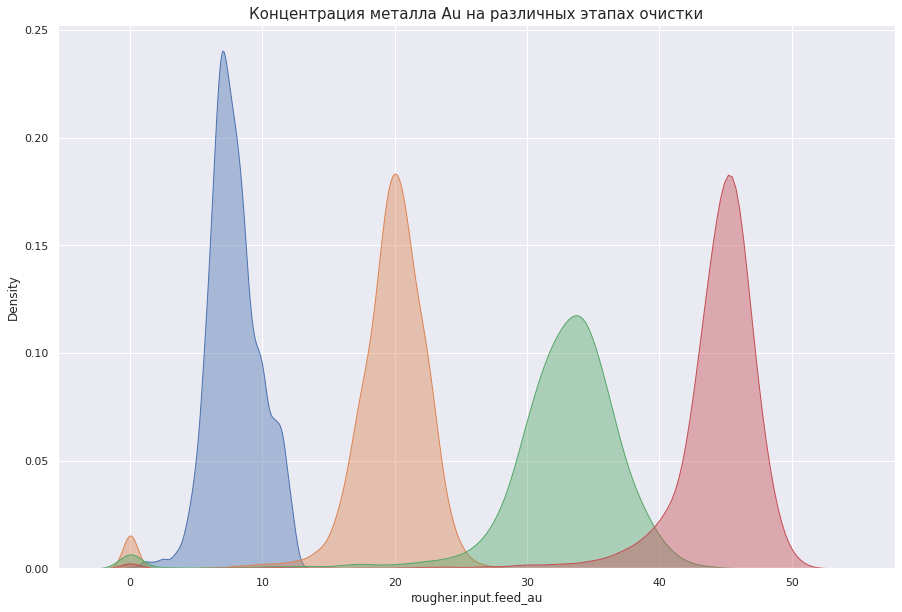

In [33]:
fraction(elements['золото'])

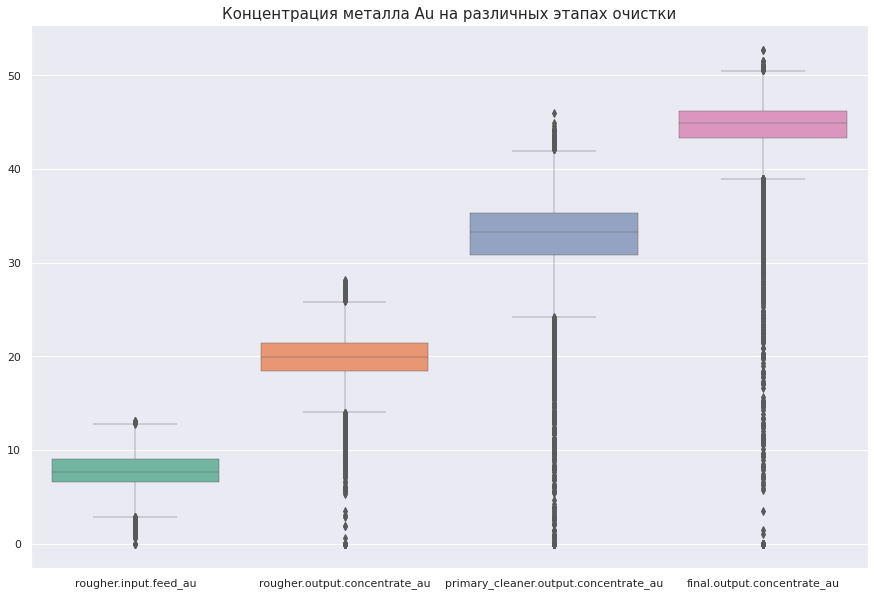

In [34]:
boxplot(elements['золото'])

The graphs show that the concentration of the gold content increases as the purification proceeds and reaches its maximum values at the end of the technological process, which is quite logical. It is worth noting the presence of outliers and the presence of zero values.

#### Silver concentration analysis

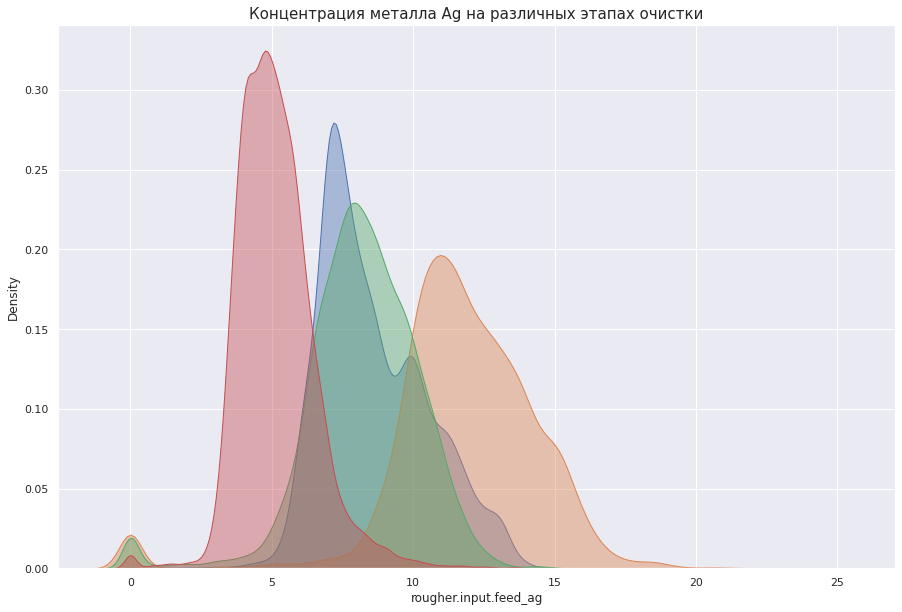

In [35]:
fraction(elements['серебро'])

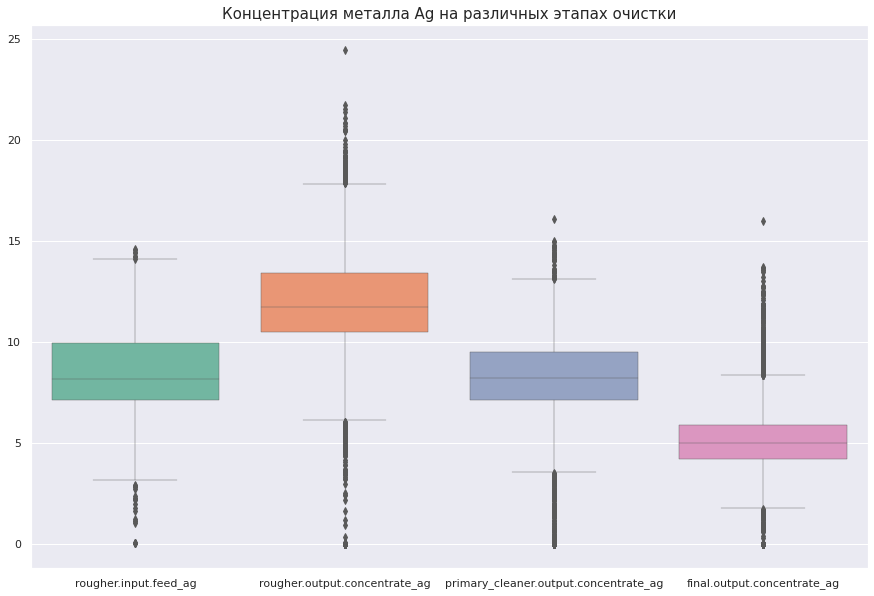

In [36]:
boxplot(elements['серебро'])

We see that the concentration of the silver content increases at the end of the flotation stage and begins to decrease as the purification progresses

#### Lead concentration analysis

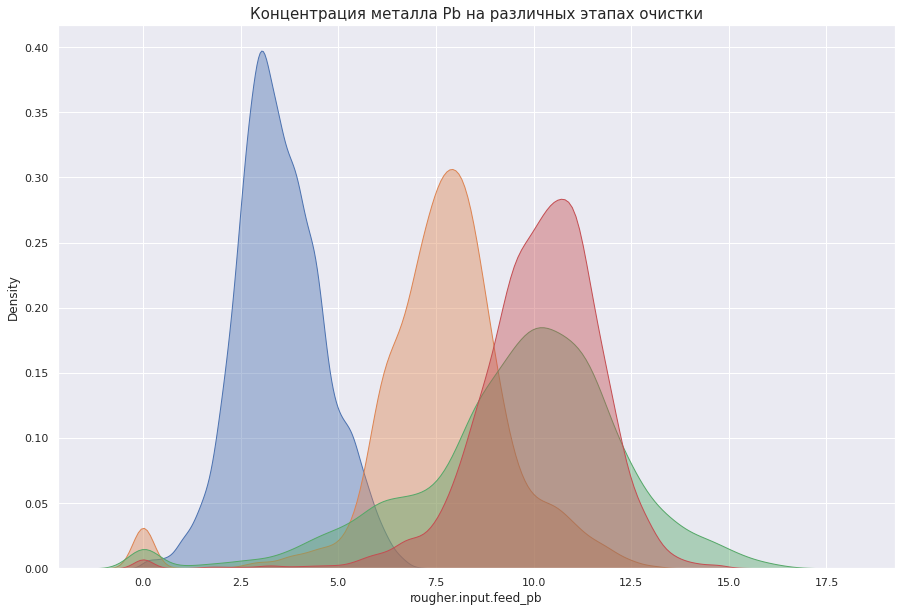

In [37]:
fraction(elements['свинец'])

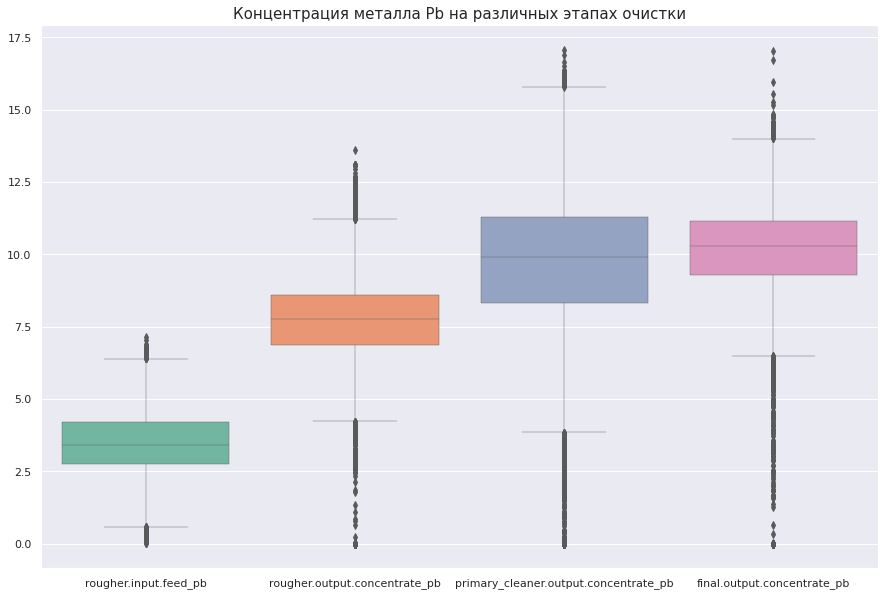

In [38]:
boxplot(elements['свинец'])

We see that the lead content begins to rise at the end of the flotation stage and remains or increases slightly during the purification stages. 

**Conclusion:**

as a result of the analysis of the concentration of elements, the following was obtained:

   - the concentration of gold content increases with purification and reaches its maximum at the end of the technological process
   - the concentration of silver content increases after flotation is completed and begins to decrease as it is cleaned
   - the concentration of lead content increases at the end of the flotation stage and remains or slightly increases during the cleaning stage

### Comparison of raw material granule distributions

Let's look at the sizes of granules of raw materials at various stages of processing.

#### Granule size of raw material stage rougher

Let's look at the sizes of the raw material granules of the rougher stage

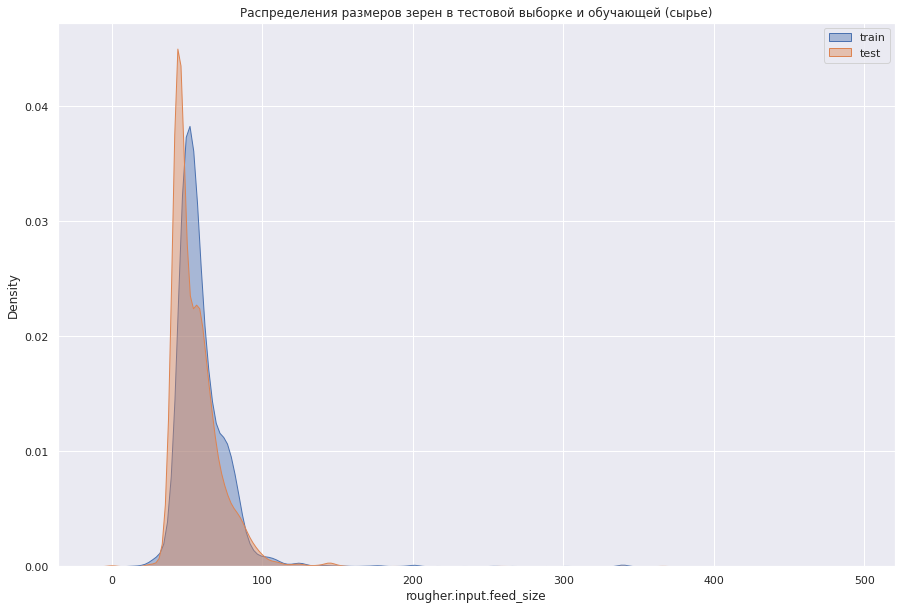

In [39]:
# distribution diagram of raw material granules in training and test samples
plt.figure(figsize=(15,10))
sns.kdeplot(data_train['rougher.input.feed_size'].dropna(), label='train', shade=True, alpha=.42)
sns.kdeplot(data_test['rougher.input.feed_size'].dropna(), label='test', shade=True, alpha=.42)
plt.title('Распределения размеров зерен в тестовой выборке и обучающей (сырье)')
plt.legend()
plt.show()

To assess the difference in the variance of our samples on the basis of rougher.input.feed_size, we will carry out the Levene test.

In [40]:
sample_1 = data_train['rougher.input.feed_size'].dropna()
sample_2 = data_test['rougher.input.feed_size'].dropna()

alpha = 0.05
stat, p = st.levene(sample_1, sample_2)
result_levene = p

if result_levene < alpha:
    print('Отвергаем Н0, дисперсии различаются')
else:
    print("Не отвергаем Н0, дисперсии не различаются")

var_sample = [np.var(x, ddof=1) for x in [sample_1, sample_2]]
print('Дисперсии по выборкам: ', var_sample)

Не отвергаем Н0, дисперсии не различаются
Дисперсии по выборкам:  [529.2442700162884, 364.05914924763465]


The distributions are similar. There are slight differences, but this should not interfere with learning. Sample variances differ slightly.

#### Granule size of raw material stage primary_cleaner

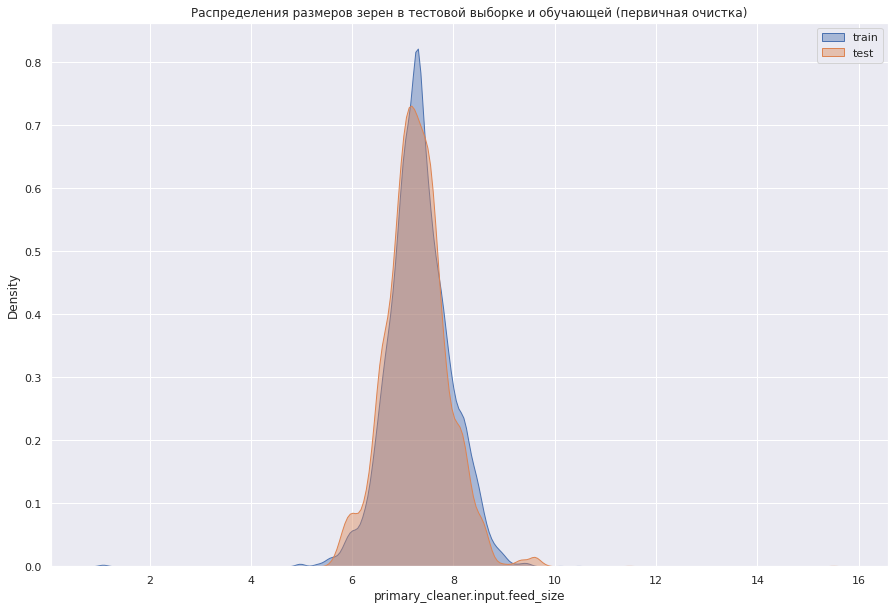

In [41]:
# distribution diagram of raw material granules in training and test samples
plt.figure(figsize=(15,10))
sns.kdeplot(data_train['primary_cleaner.input.feed_size'].dropna(), label='train', shade=True, alpha=.42)
sns.kdeplot(data_test['primary_cleaner.input.feed_size'].dropna(), label='test', shade=True, alpha=.42)
plt.title('Распределения размеров зерен в тестовой выборке и обучающей (первичная очистка)')
plt.legend()
plt.show()

To assess the difference in the variance of our samples on the basis of primary_cleaner.input.feed_size, we will carry out the Levene test.

In [42]:
sample_1_1 = data_train['primary_cleaner.input.feed_size'].dropna()
sample_2_1 = data_test['primary_cleaner.input.feed_size'].dropna()

alpha = 0.05
stat, p = st.levene(sample_1_1, sample_2_1)
result_levene = p

if result_levene < alpha:
    print('Отвергаем Н0, дисперсии различаются')
else:
    print("Не отвергаем Н0, дисперсии не различаются")

var_sample = [np.var(x, ddof=1) for x in [sample_1_1, sample_2_1]]
print('Дисперсии по выборкам: ', var_sample)

Не отвергаем Н0, дисперсии не различаются
Дисперсии по выборкам:  [0.37707246424697644, 0.37236694849972296]



The distributions are similar and the sample variances do not differ.

**Conclusion:**

comparing the size of raw material granules for the training and test samples at different stages, we can conclude that their distributions are similar and the variances for the samples do not differ or differ slightly.

### Study of the total concentrations of substances depending on the stage of processing

Here we consider the total concentrations of substances depending on the following stages of processing:

   - in raw materials
   - in crude concentrates
   - in final concentrates

In [43]:
# determine the total concentration of substances
sum_concentrate = {'rougher':[x for x in data_full.columns if x.startswith('rougher.output.concentrate')],
               'primary_cleaner':[x for x in data_full.columns if x.startswith('primary_cleaner.output.concentrate')],
               'final':[x for x in data_full.columns if x.startswith('final.output.concentrate')]}

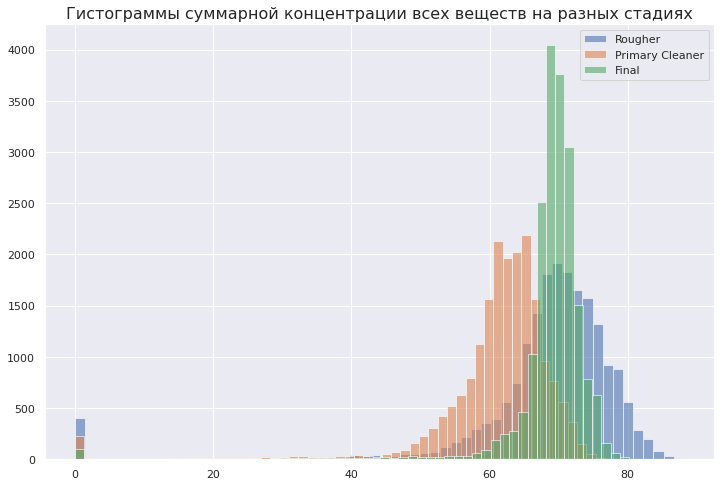

In [44]:
# build a histogram of the total concentration of all substances at different stages
plt.figure(figsize=(12, 8))
for key in sum_concentrate:
    np.sum(data_full[sum_concentrate[key]], axis=1).hist(bins = 60, alpha = 0.6 )
plt.title('Гистограммы суммарной концентрации всех веществ на разных стадиях', size = 16)
plt.legend(['Rougher', 'Primary Cleaner', 'Final'])
plt.show()  

We see a small number of zero values. For the total indicator, this most likely means that the concentrate was basically absent, that is, the interruption of the process. To predict the results of the process, only data for the periods when it was going should be left. Therefore, what is less than 20% will be removed.

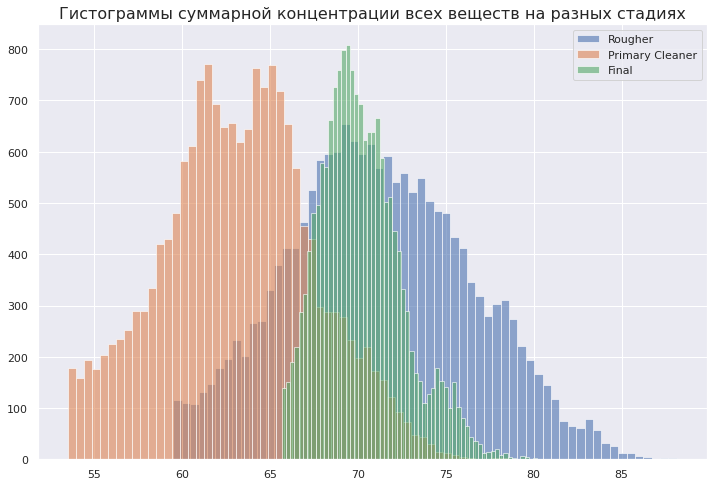

In [45]:
plt.figure(figsize=(12, 8))
for key in sum_concentrate:
    df = np.sum(data_full[sum_concentrate[key]], axis=1)
    cut_point = np.percentile(df, 10)
    df[df>cut_point].hist(bins = 60, alpha = 0.6 )
plt.title('Гистограммы суммарной концентрации всех веществ на разных стадиях', size = 16)
plt.legend(['Rougher', 'Primary Cleaner', 'Final'])
plt.show() 

**Conclusion:**

during the study, zero values were identified, as a result of which it can be concluded that the technological process was interrupted.

Let's analyze multicollinearity. Visually evaluate the overall picture on the training sample.

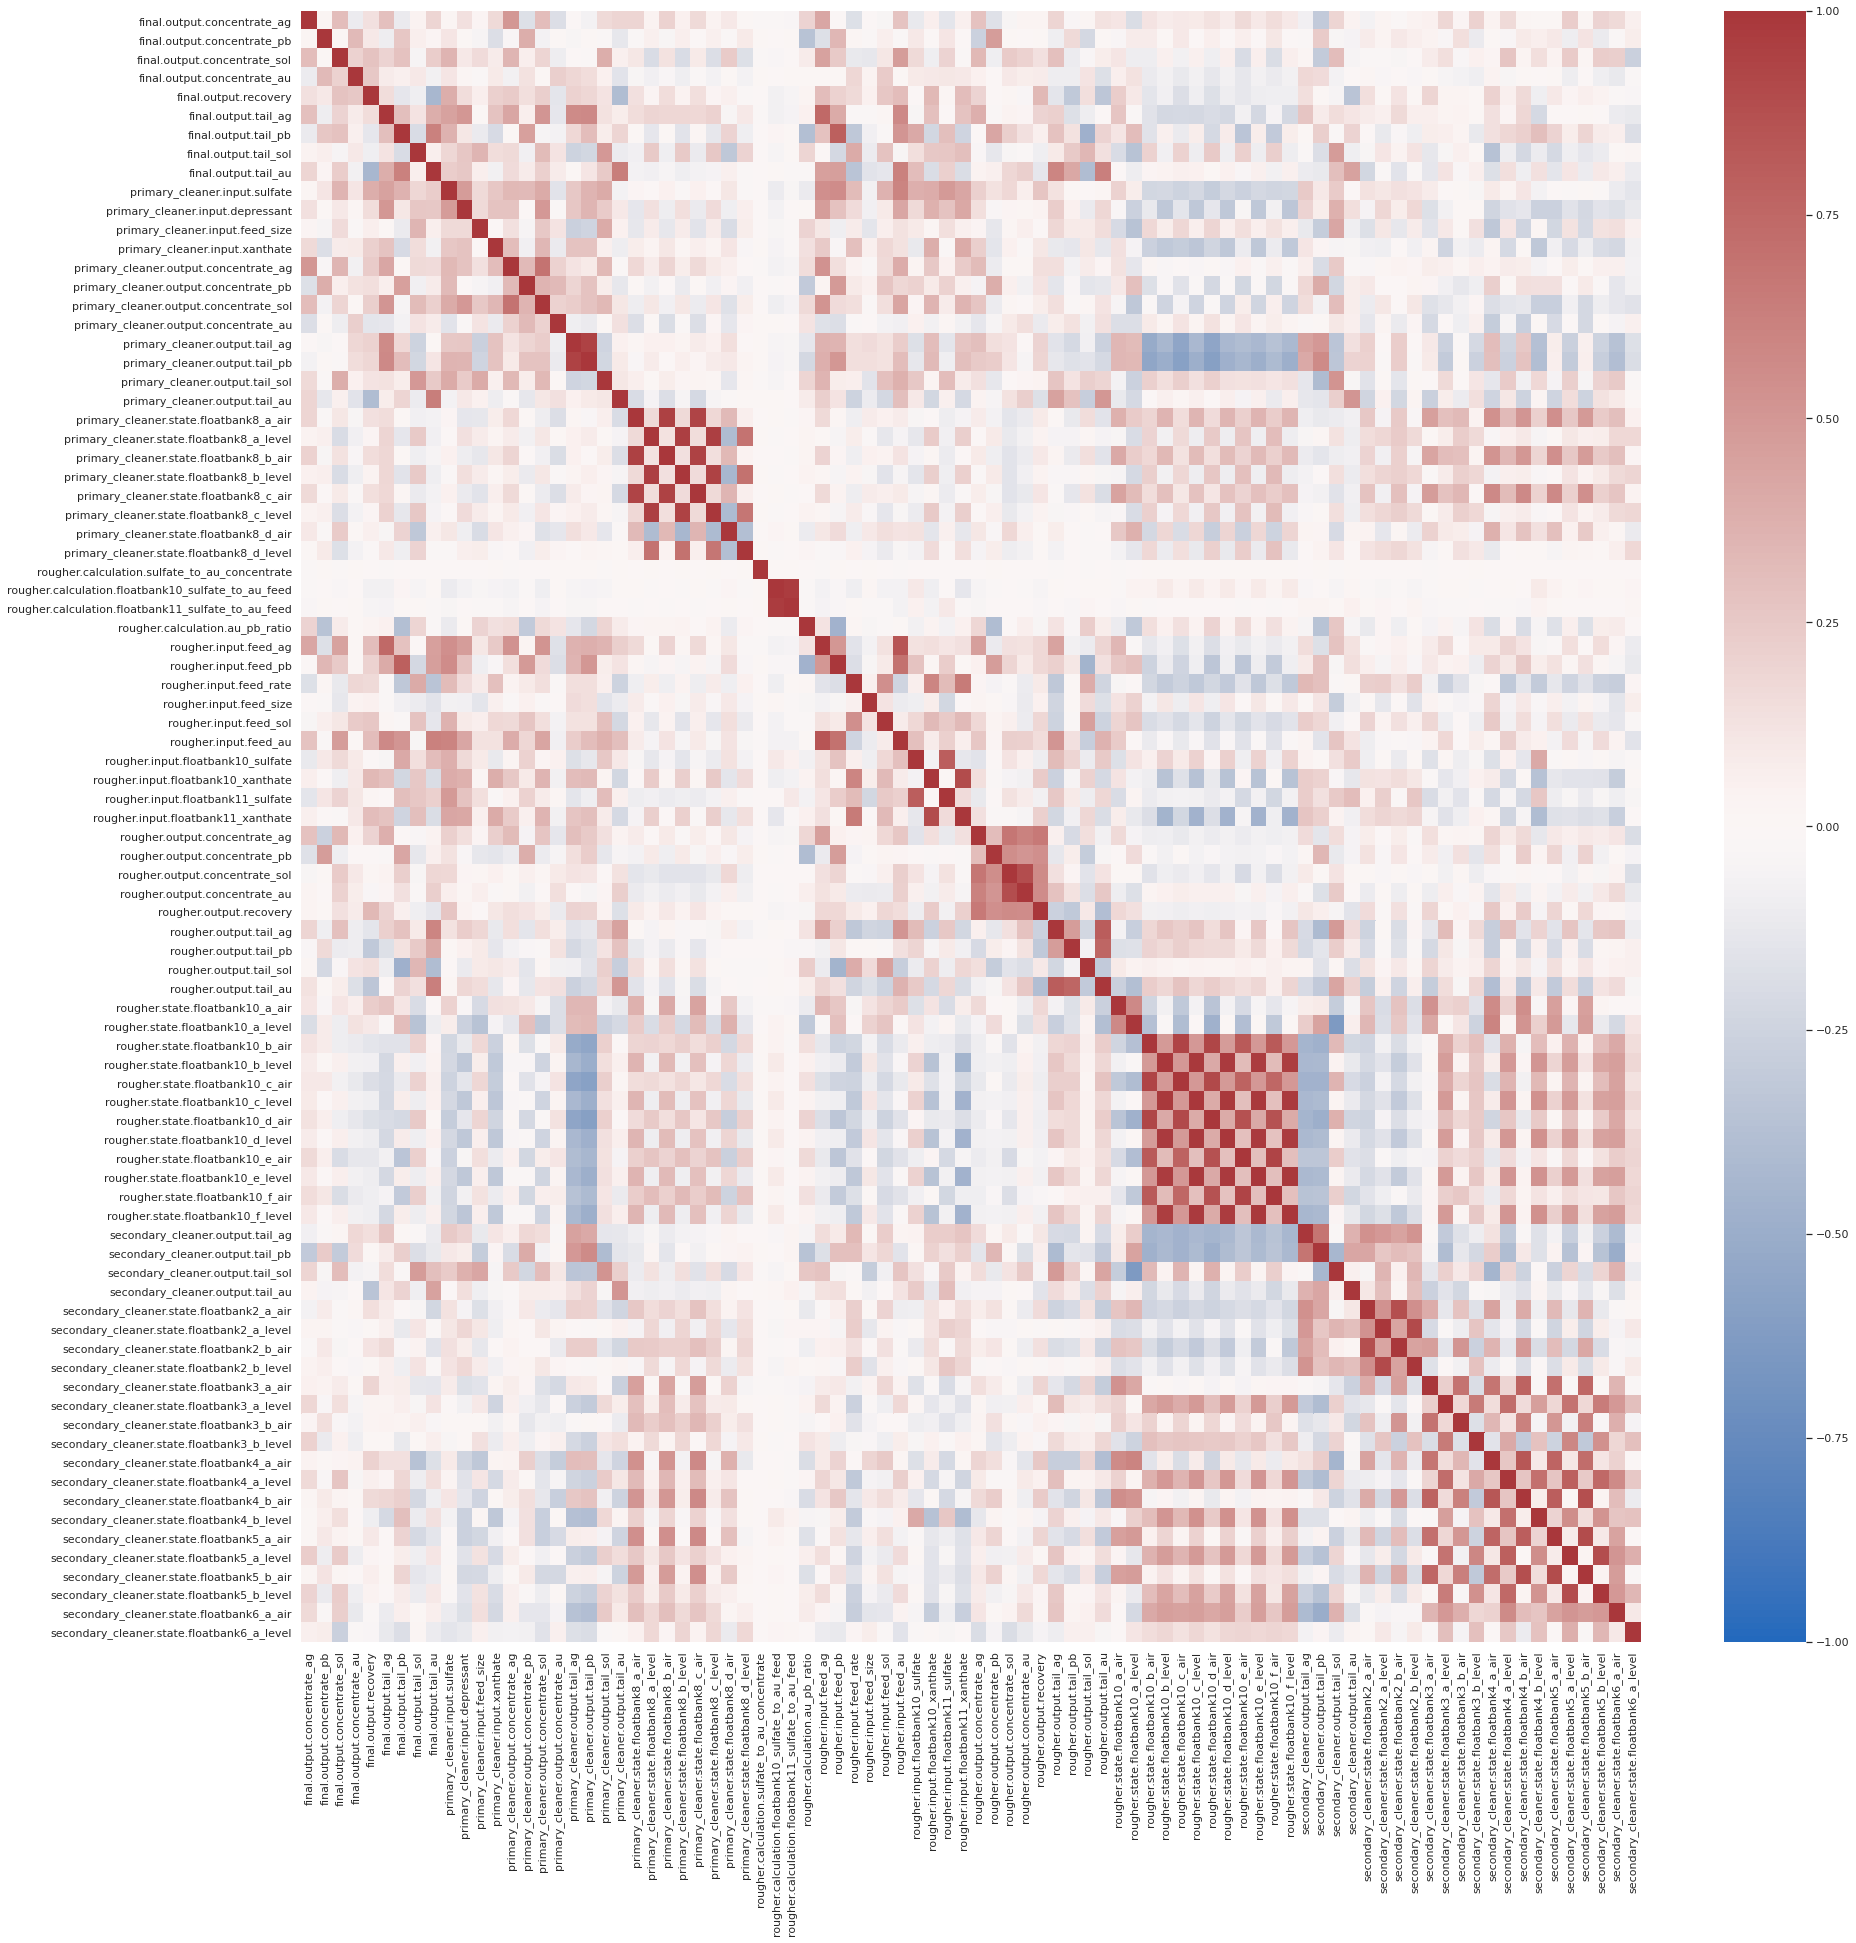

In [46]:
plt.figure(figsize=(30, 30))
sns.heatmap(data_train.corr(), vmin = -1, vmax = 1, cmap = 'vlag')
plt.show()

The floatbank indicators are highly correlated with each other, when forming the input features for the models, we will leave those that have the greatest relationship with the target features and remove the rest

### Conclusion

During the analysis of the data, the following was obtained:

   - the concentration of gold content increases with purification and reaches its maximum at the end of the technological process
   
   - the concentration of silver content increases after flotation is completed and begins to decrease as it is cleaned
   
   - the concentration of lead content increases at the end of the flotation stage and remains or slightly increases during the cleaning stage
   
   - comparing the size of raw material granules for the training and test samples at different stages, we can conclude that their distributions are similar and the variances for the samples do not differ or differ slightly.

   - on this step of researching the total concentrations of substances depending on the various stages of the process, zero values were found, as a result of which it can be concluded that the process was interrupted.

   - if we analyze multicollinearity, the floatbank indicators are highly correlated with each other, when forming the input features for the models, we will leave those that have the greatest relationship with the target features and remove the rest

## Model

On this step we will do:

   1. write a function to determine the totals sMAPE
    
   2. train and evaluate the quality of models
    
   3. model testing

### Function for determining sMAPE totals

We have sMAPE as a quality metric

 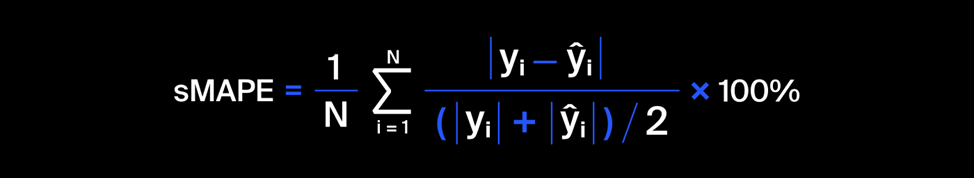
 

And we need to evaluate the result as 25% * sMAPE(rougher) + 75% * sMAPE(final)

Let's create a function to calculate

In [47]:
# write a function to calculate sMAPE
def smape(y_target, y_pred):
    return ((1 / len(y_target)) * np.sum(2 * np.abs(y_target - y_pred) / (np.abs(y_target) + np.abs(y_pred)))) * 100

In [48]:
# write a function to calculate final sMAPE
def smape_final(rough, final):
    return 0.25 * rough + 0.75 * final

In [49]:
smape_scoring = make_scorer(smape, greater_is_better=False)

We will form the signs on the basis of which we will train the model. To predict the enrichment efficiency after the first stage, we will use indicators related only to it

In [50]:
rougher_features = []
for column in data_train.columns:
    if ("rougher" in column):
        rougher_features.append(column)

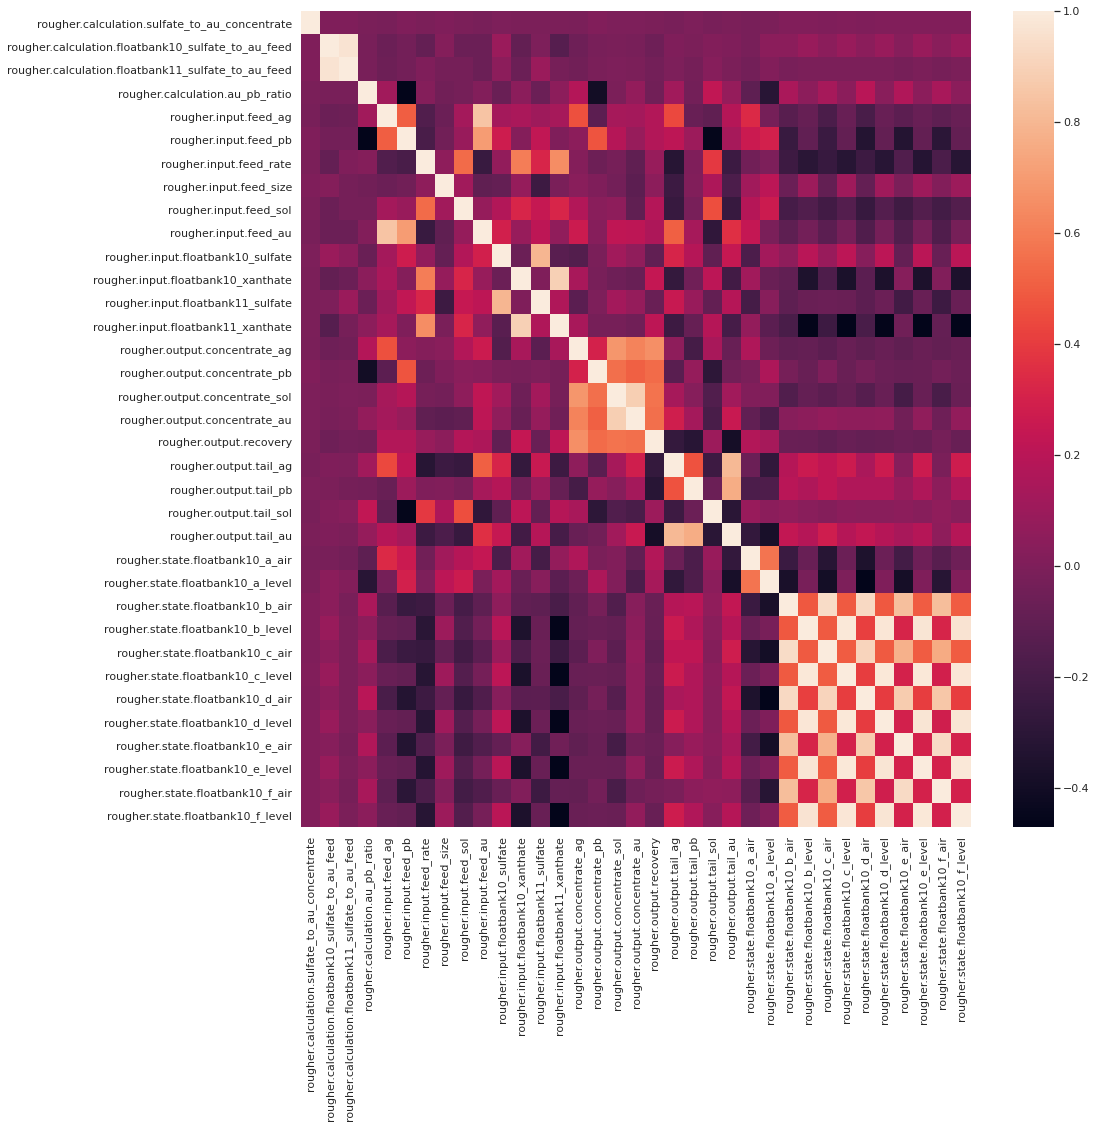

In [51]:
plt.figure(figsize=(15, 15))
sns.heatmap(data_train[rougher_features].corr())
plt.show()

In [51]:
rougher_features = ['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level']

In [53]:
final_features = []
for column in data_train.columns:
    if not("rougher" in column):
        final_features.append(column)

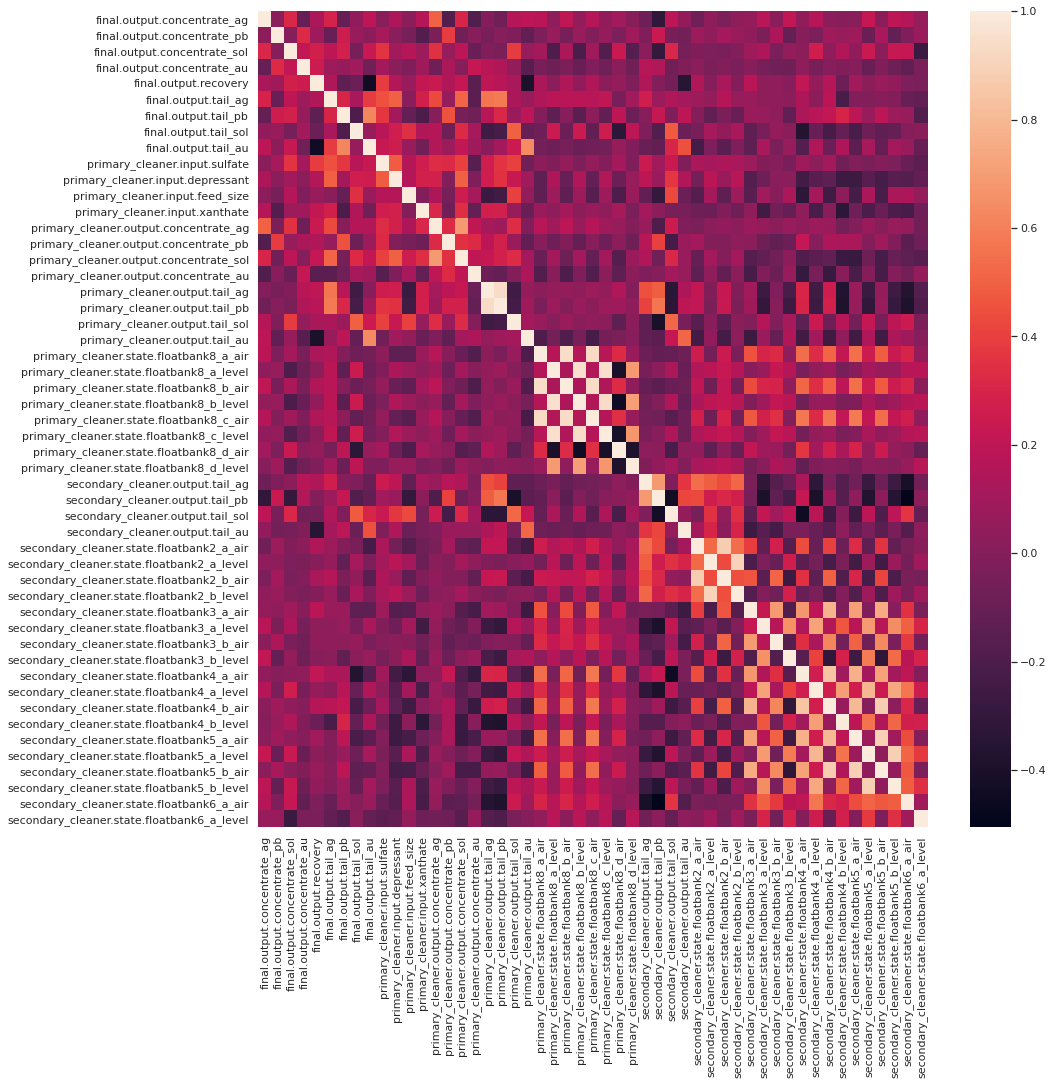

In [54]:
plt.figure(figsize=(15, 15))
sns.heatmap(data_train[final_features].corr())
plt.show()

In [52]:
final_features = ['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank4_a_level'
]

### Building and testing models

Prepare samples and train the following models:

   - Linear Regression
   - Random Forest Regrassor
   - Decision Tree Regrassor
   - Support Vector Regressor
   - KNN Regressor
   - Lasso Regressor
   - Ridge Regressor
    
Let's also compare the data with the constant model

Two models need to be trained for two target features rougher.output.recovery and final.output.recovery.
To assess the quality of the model, we will use cross validation.

In [53]:
# Divide samples into features and target feature for the flotation step
features_train_rougher = data_train[rougher_features]
target_train_rougher = data_train['rougher.output.recovery']
features_test_rougher = data_test[rougher_features]
target_test_rougher = data_test['rougher.output.recovery']

print(features_train_rougher.shape)
print(target_train_rougher.shape)
print(features_test_rougher.shape)
print(target_test_rougher.shape)

(14149, 10)
(14149,)
(5290, 10)
(5290,)


In [54]:
# divide the samples into features and the target feature for the final stage
features_train_final = data_train[final_features + rougher_features]
target_train_final = data_train['final.output.recovery']
features_test_final = data_test[final_features + rougher_features]
target_test_final = data_test['final.output.recovery']

print(features_train_final.shape)
print(target_train_final.shape)
print(features_test_final.shape)
print(target_test_final.shape)

(14149, 18)
(14149,)
(5290, 18)
(5290,)


In [58]:
target_test_final

date
2016-09-01 00:59:59    70.273583
2016-09-01 01:59:59    68.910432
2016-09-01 02:59:59    68.143213
2016-09-01 03:59:59    67.776393
2016-09-01 04:59:59    61.467078
                         ...    
2017-12-31 19:59:59    68.919891
2017-12-31 20:59:59    68.440582
2017-12-31 21:59:59    67.092759
2017-12-31 22:59:59    68.061186
2017-12-31 23:59:59    71.699976
Name: final.output.recovery, Length: 5290, dtype: float64

In [55]:
# get the value of the constant model
dummy_regr = DummyRegressor(strategy='median')
dummy_regr_2 = DummyRegressor(strategy='median')
dummy_regr.fit(features_train_rougher, target_train_rougher)
dummy_regr_2.fit(features_train_final, target_train_final)
Dummy_predictions = dummy_regr.predict(features_test_rougher)
Dummy_predictions_2 = dummy_regr_2.predict(features_test_final)
rough = smape(target_test_rougher, Dummy_predictions) 
final = smape(target_test_final, Dummy_predictions_2)
dummy_final = smape_final(rough, final)
dummy_final

9.479919198122861

We use pipline to train several models. And in the training model we will use cross-validation.

In [56]:
pipelines = []
rand = 1
pipelines.append(('Linear Regression' ,
                  (Pipeline([('scaled' , MinMaxScaler()),
                             ('LR' ,LinearRegression())]))))
pipelines.append(('Random Forest Regressor' ,
                  (Pipeline([('scaled' , MinMaxScaler()),
                             ('RFR' ,RandomForestRegressor(random_state=rand))]))))
pipelines.append(('Decision Tree Regressor' ,
                  (Pipeline([('scaled' , MinMaxScaler()),
                             ('DT' ,DecisionTreeRegressor(random_state=rand))]))))
pipelines.append(('Support Vector Regressor' ,
                  (Pipeline([('scaled' , MinMaxScaler()),
                             ('SVR' , SVR())]))))
pipelines.append(('KNN Regressor',
                  (Pipeline([('scaled', MinMaxScaler()),
                             ('KNN', KNeighborsRegressor(n_neighbors=50))]))))
pipelines.append(('Lasso Regressor',
                  (Pipeline([('scaled', MinMaxScaler()),
                             ('Lasso', Lasso(random_state=rand))]))))
pipelines.append(('Ridge Regressor',
                  (Pipeline([('scaled', MinMaxScaler()),
                             ('Ridge', Ridge(random_state=rand))]))))

model_name = []
results = []
for pipe, model in pipelines:
    kfold = KFold(n_splits=3, shuffle= True)
    crossv_results_rougher = cross_val_score(model, features_train_rougher, target_train_rougher, cv = kfold, scoring=smape_scoring)
    crossv_results_final = cross_val_score(model, features_train_final, target_train_final, cv = kfold, scoring=smape_scoring)
    results.append(abs(smape_final(crossv_results_rougher, crossv_results_final)))
    model_name.append(pipe)
    msg = "%s: %f (%f)" % (pipe, np.mean(results[-1]), np.std(results[-1]))
    print(msg)

Linear Regression: 9.591287 (0.155692)
Random Forest Regressor: 7.227328 (0.210893)
Decision Tree Regressor: 9.644007 (0.177490)
Support Vector Regressor: 8.361984 (0.186874)
KNN Regressor: 8.235216 (0.262061)
Lasso Regressor: 11.294077 (0.049244)
Ridge Regressor: 9.584613 (0.129871)


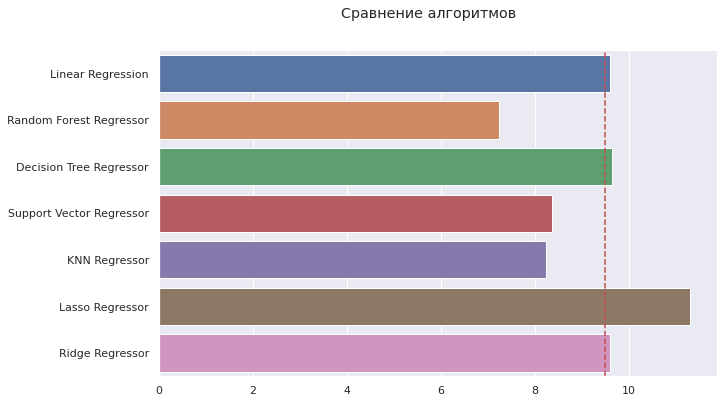

In [57]:
# comparison of algorithms
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Сравнение алгоритмов')
ax = fig.add_subplot(111)
sns.barplot(x = np.mean(results, axis = 1), y = model_name)

plt.axvline(dummy_final, color = 'r', linestyle = '--')
plt.show()

During the training of models, half of the models show worse results than on a constant model. But some models showed very good results:

   - for the Random Forest Regressor model, the final value of sMAPE is 7.25
   - for the KNN Regressor model, the final value of sMAPE is 8.24
   - for the Support Vector Regressor model, the final value of sMAPE is 8.35
    
Thus, for testing, we will use two models with the best results: Random Forest Regressor and KNN REgressor

### Models testing

#### Testing RandomForestRegressor

In [61]:
# mix the data for more successful model training
features_train_rougher_shuffled = shuffle(features_train_rougher, random_state = 12345)
features_test_rougher_shuffled = shuffle(features_test_rougher, random_state = 12345)
target_train_rougher_shuffled = shuffle(target_train_rougher, random_state = 12345)
target_test_rougher_shuffled = shuffle(target_test_rougher, random_state = 12345)
features_train_final_shuffled = shuffle(features_train_final, random_state = 12345)
features_test_final_shuffled = shuffle(features_test_final, random_state = 12345)
target_train_final_shuffled = shuffle(target_train_final, random_state = 12345)
target_test_final_shuffled = shuffle(target_test_final, random_state = 12345)

In [62]:
# train the RandomForestRegressor model for rougher
pipe = Pipeline([('scaled', MinMaxScaler()), ('RFR', RandomForestRegressor(random_state=rand))])
pipe.fit(features_train_rougher_shuffled, target_train_rougher_shuffled)
pred_rougher = pipe.predict(features_test_rougher_shuffled)
rougher = smape(target_test_rougher_shuffled, pred_rougher)

In [63]:
# train the RandomForestRegressor model for final
pipe_final = Pipeline([('scaled', MinMaxScaler()), ('RFR', RandomForestRegressor(random_state=rand))])
pipe_final.fit(features_train_final_shuffled, target_train_final_shuffled)
pred_final = pipe_final.predict(features_test_final_shuffled)
final = smape(target_test_final_shuffled, pred_final)

In [64]:
# final sMAPE
smape_final(rougher, final)

10.062810814857094

The value on the test sample is much worse than on the training one, and in addition, this value is worse than the value on the constant model. Shuffling rows did not lead to better results

#### Testing KNNRegressor

In [65]:
pipe_KNN = Pipeline([('scaled', MinMaxScaler()), ('KNN', KNeighborsRegressor(n_neighbors=50))])
pipe_KNN.fit(features_train_rougher_shuffled, target_train_rougher_shuffled)
pred_rougher = pipe_KNN.predict(features_test_rougher_shuffled)
rougher = smape(target_test_rougher_shuffled, pred_rougher)

In [66]:
pipe_KNN_final = Pipeline([('scaled', MinMaxScaler()), ('KNN', KNeighborsRegressor(n_neighbors=50))])
pipe_KNN_final.fit(features_train_final_shuffled, target_train_final_shuffled)
pred_final = pipe_KNN_final.predict(features_test_final_shuffled)
final = smape(target_test_final_shuffled, pred_final)

In [67]:
smape_final(rougher, final)

8.825816090052168

This model showed worse results on the test sample than on the training one, but the results deteriorated slightly, in addition, this value is less than what was learned on the constant model. So we have an adequate model.

#### Conclusion

In this section, several models were trained, some of them showed poor results, and some showed very good results on the training set. The following models were selected to test the models on the test sample:

   - Random Forest Regressor (final sMAPE = 7.25)
   - KNN Regressor (final sMAPE = 8.25)
    
Final sMAPE for constant model: 9.47

On the test sample, the following results were obtained:

   - KNN Regressor (final sMAPE = 8.82)
   - Random Forest Regressor (final sMAPE = 10.06)
    
Thus, we can recommend the KNN Regressor model as a predictive model. In addition, this model is trained quite quickly.

## General conclusion

During data preparation, it was determined:

   - data and data types match the description, no duplicates, missing values were found
   - the ratio of test and training samples: 27.3% and 72.7%, respectively
   - the distribution of some features differs from normal, there are outliers
   - MAE is equal to 9.7 * 10e-15, this indicator is negligible, so the calculations are correct
   - in the test sample, there are no output parameters of the product at each stage of the technical process, and calculated signs at each stage of flotation
   - at the preprocessing stage, the gaps were filled in, and target features were added to the test sample.
    
    
During the analysis of the data, the following was obtained:

   - the concentration of gold content increases with purification and reaches its maximum at the end of the technological process
   - the concentration of silver content increases after flotation is completed and begins to decrease as it is cleaned
   - the concentration of lead content increases at the end of the flotation stage and remains or slightly increases during the cleaning stage
    
   - Comparing the size of raw material granules for the training and test samples at different stages, we can conclude that their distributions are similar and the variances for the samples do not differ or differ slightly.

   - in the course of studying the total concentrations of substances, depending on the various stages of the process, zero values were found, as a result of which it can be concluded that the process was interrupted.

   - if we analyze multicollinearity, the floatbank indicators are highly correlated with each other, when forming the input features for the models, we will leave those that have the greatest relationship with the target features and remove the rest
    

During the study of training models, several models were trained, some of them showed poor results, and some showed very good results on the training set. The following models were selected to test the models on the test sample:

   - Random Forest Regressor (final sMAPE = 7.25)
   - KNN Regressor (final sMAPE = 8.25)
    
On the test sample, the following results were obtained:

   - KNN Regressor (final sMAPE = 8.82)
   - Random Forest Regressor (final sMAPE = 10.06)
    
Thus, we can recommend the KNN Regressor model as a predictive model. In addition, this model is trained quite quickly.